<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:4px 4px;">Objectives</p>

### About CYGNSS Mission
+ The CYGNSS launched on 15 December 2016 by NASA.
+ The Constillation of the CYGNSS is made up of eight microsatellites.
+ The observatories provide nearly gap-free earth coverage using an orbital inclination of approximately 35° from the equator, with a mean revisit time of 6 hrs and a median revisit time of three hours. 
+ This inclination allows CYGNSS to measure ocean surface winds between approximately 38° N and 38° S latitude.

### 1. Sensitivity analysis of the SR and soil moisture
#### **1.1 Downloading CYGNSS Data for 2020 of latest version 3.0**
   + Manually it is impossible to download CYGNSS data
   + **Reason**:
     + In a single year there are 365 folders each containing 8 files in NetCDF format
     + Each file is of 1.3GB containing data for the whole globe
     + Subsetting option is available with respect to variables only
     + But manually selecting variables for each and every file is impossible
     + **Main challenge here is subsetting CYGNSS Data** with respect to the variables and the region
     + **Written python script for downloading 2020 data of version 3.0 and 2.1** 
       
#### 1.2 Visualization of main basic observable of CYGNSS which is DDM
   + Stored in CYGNSS as a variable name 'Power Analog'
   + DDM is the actual power which DDMI is receiving 
   
#### 1.3 Calculating Surface Reflectivity from CYGNSS satellite data
   + Surface reflectivity is the attenuated power after correction applied on the received power 
   + Used Bistatic Radar equation for surface reflectivity 
   
#### 1.4 Regridding Surface Reflectivity of CYGNSS data on the SMAP grid
   + Resolution of surface reflectivity is varying from 0.5x3.5 Km to 25x25 Km based on the target point
   + Downloading the soil moisture data of 2020 from SMAP available in NetCDF format
   + Soil Moisture is in the different resolution of 36x36 Km
   + Corresponding a single pixel of SMAP made averaging surface reflectivity
   
#### 1.5 Correlating regridded surface reflectivity with the SMAP soil moisture 
   + For each and every pixel point of SMAP made averaging of surface reflectivity throughout the year 2020
   + More than 80 % temporal correlation is found between SR and SM for each and every pixels
   
+ **Key words** :
    + surface reflectivity : SR
    + soil moisture : SM

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Libraries : </p>

In [1]:
import warnings
warnings.filterwarnings("ignore")

from netCDF4 import Dataset
import numpy as np
import pandas as pd
from pandas import DataFrame
import seaborn as sns
from scipy.stats import skew
import matplotlib.pyplot as plt
import geopandas as gpd 

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> CYGNSS data </p>

#### Paths of CYGNSS Satellites within the Area of Interest

In [2]:
import Visualize_CYGNSS_Data
import imp
imp.reload(Visualize_CYGNSS_Data)
import Visualize_CYGNSS_Data as V1

In [3]:
%%time
#V1.Plotting_CYGNSS(d=3)

Wall time: 0 ns


<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Basic Observables</p>

### Reading the daily CYGNSS data : 2020

In [4]:
data = Dataset('D:\EG\Project Data\CYGNSS DATA\Day_361\cyg01.ddmi.s20201226-000000-e20201226-235959.l1.power-brcs.a30.d31.nc.nc','r')

### Basic observable power analog :

In [5]:
v12 =  data.variables['power_analog'][:]             
v12.shape

(170001, 4, 17, 11)

+ 17 Delay × 11 Doppler (in Watt) bins corresp. to 50 $km^2$

### Removing noise from the data

In [6]:
u_12 = v12.reshape(len(v12.flatten()),)
v_12 = pd.DataFrame(u_12)
V_12 = v_12.replace(to_replace=-9999,value=np.nan)
M    = V_12.to_numpy()
P12  = M.reshape(len(v12),4,17,11)

### DDM corresponding to a single specular point :

In [7]:
P = P12
DDM_Sample0_Pile1 = P[0][0][:][:]
DDM_Sample0_Pile1.shape

(17, 11)

### Visualizing the DDM of different features in the Ganga catchment :

In [8]:
%%time
SP_Latitude = []
SP_Longitude = []
SP_DDM = []
v1f =  data.variables['sp_lat'][:]
v2f =  data.variables['sp_lon'][:]
for i in range(len(v1f)):
    for j in range(4):
        a = v1f[i][j]
        b = v2f[i][j]
        if a>=21 and a<=31 and b>=73 and b<=89:
            F3 = P[i][j][:][:]
            SP_DDM.append(F3)
            SP_Latitude.append(a)
            SP_Longitude.append(b)
            
SPLat = np.array(pd.DataFrame(SP_Latitude))
SPLon = np.array(pd.DataFrame(SP_Longitude))
SPDDM = np.array(SP_DDM)

Wall time: 16 s


In [9]:
def DDM_Map(i):
    a = np.round(float(SPLat[i][0]),2)
    b = np.round(float(SPLon[i][0]),2)
    F3 = SPDDM[i]
    
    # Delay Doppler Shifts in 500 Hz resolution
    DS = np.array([-5,-4,-3,-2,-1,0,1,2,3,4,5])*0.5
    
    # Delay Chips in 0.25 resolution
    CP = np.array([8,7,6,5,4,3,2,1,0,-1,-2,-3,-4,-5,-6,-7,-8])  
    DS,CP = np.meshgrid(DS,CP)
    
    plt.figure(figsize=(8,10))
    img = plt.pcolor(DS,CP,F3,cmap='magma')
    plt.xlabel('Doppler Shift (kHz)',size=25)
    plt.ylabel('Delay (Chips)',size=25)
    cbar = plt.colorbar(img)
    plt.clim(0, 10**(-16.4))
    cbar.set_label('Power in W/m2',fontsize=25)
    cbar.ax.tick_params(labelsize=15)
    plt.tick_params(axis='both', which='major', labelsize=20)
    Title = f'''Latitude:{a}° N
Longitude:{b}° E'''
    plt.title(f'{Title}',fontsize=25)

### The observables that are commonly used for soil moisture estimation are :
1. The peak of each DDM 
2. Or the peak divided by the noise floor ( DDM SNR )

### Finding the DDM peak value

In [10]:
df1 = []
for i in range(len(P)):
    for j in range(4):
        a = np.max(P[i][j][:])
        df1.append(a)
        
df2 = np.array(df1)
DDM_peak = df2.reshape(len(P),4)
DDM_peak.shape

(170001, 4)

In [11]:
DDM_peak

array([[          nan,           nan,           nan,           nan],
       [          nan,           nan,           nan,           nan],
       [2.0649563e-17, 2.5518534e-18, 1.8869557e-18, 2.0296387e-17],
       ...,
       [3.3056443e-18, 1.4132420e-17, 1.0452259e-18, 1.0684340e-17],
       [2.3045649e-18, 1.5733070e-17, 8.4997295e-19, 1.0581499e-17],
       [2.2721330e-18, 1.3292951e-17, 8.7620616e-19, 1.1543866e-17]],
      dtype=float32)

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Subsetting the CYGNSS Data</p>

### Software for subsetting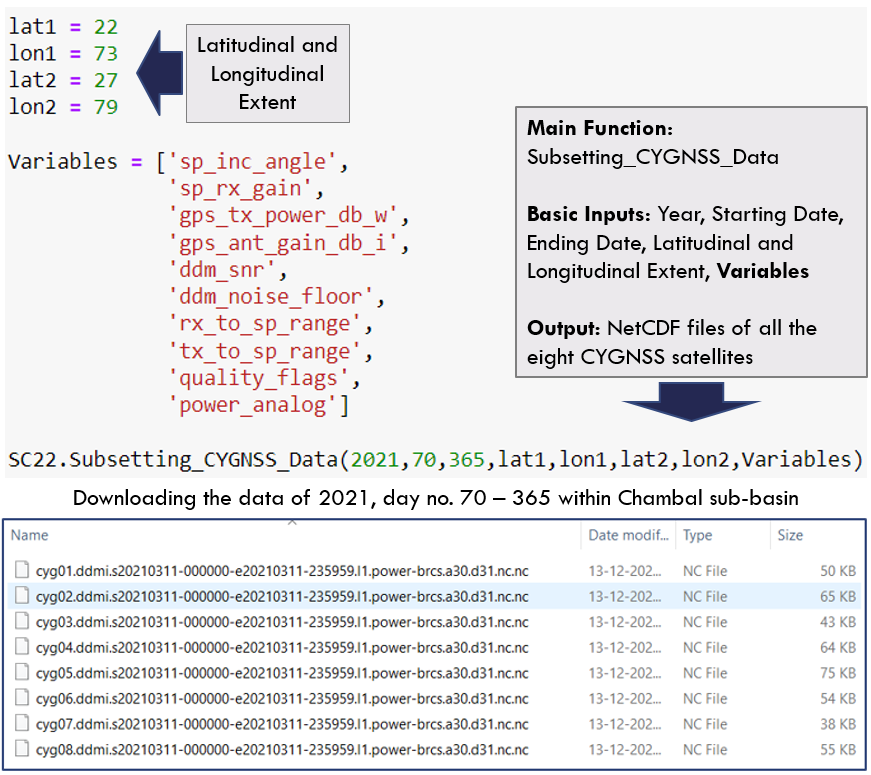

In [12]:
import BR_CYGNSS
import imp
imp.reload(BR_CYGNSS)
import BR_CYGNSS as SC22

In [13]:
# lat1 = 22
# lon1 = 73
# lat2 = 27
# lon2 = 79

# Variables = ['sp_inc_angle',
#              'sp_rx_gain',
#              'gps_tx_power_db_w',
#              'gps_ant_gain_db_i',
#              'ddm_snr',
#              'ddm_noise_floor',
#              'rx_to_sp_range',
#              'tx_to_sp_range',
#              'quality_flags',
#              'power_analog']

# SC22.Subsetting_CYGNSS_Data(2019,325,365,lat1,lon1,lat2,lon2,Variables)

###  Reading masked data

In [14]:
Cygnss_csv1 = pd.read_csv('D:\EG\Project Data\CYGNSS_CSV_Files\Day_001.csv')

In [15]:
pd.DataFrame(Cygnss_csv1.keys())

0
0                 sp_lat
1                 sp_lon
2           sp_inc_angle
3             sp_rx_gain
4      gps_tx_power_db_w
5      gps_ant_gain_db_i
6                ddm_snr
7        ddm_noise_floor
8         rx_to_sp_range
9         tx_to_sp_range
10         quality_flags
11  peak of power_analog

In [16]:
Cygnss_csv1.head()

sp_lat     sp_lon  sp_inc_angle  sp_rx_gain  gps_tx_power_db_w  \
0  24.802496  73.007675     26.162573   14.247239              13.66   
1  24.816223  73.033970     26.168324   14.242600              13.66   
2  24.829940  73.060280     26.174116   14.238091              13.66   
3  24.843658  73.086590     26.179937   14.233192              13.66   
4  24.857365  73.112910     26.185799   14.227897              13.66   

   gps_ant_gain_db_i   ddm_snr  ddm_noise_floor  rx_to_sp_range  \
0          14.767239  8.522056        5468.6235        569248.0   
1          14.767685  8.977606        5442.3780        569283.0   
2          14.768134  8.468381        5427.3535        569316.0   
3          14.768586  7.131919        5450.5557        569351.0   
4          14.769041  7.496569        5421.6323        569384.0   

   tx_to_sp_range  quality_flags  peak of power_analog  
0      20500764.0         269313          4.538676e-17  
1      20500976.0         269313          5.098621e-17  
2      20501191.0         269313          4.440568e-17  
3      20501406.0         269313          3.082364e-17  
4      20501623.0         269313          3.399072e-17

In [17]:
Cygnss_csv1.shape

(33825, 12)

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Detecting and removing Outliers </p>

In [18]:
def Skewness(Skw):
    if Skw>0:
        return "Positively Skewed"
    else:
        return "Negatively Skewed"

def Outlier_Detection(DF,V):
    DF = pd.DataFrame(DF)
    DF = DF.replace(to_replace=-9999,value=np.nan)
    DF = DF.dropna()
    DF = np.array(DF)
    Skw = (skew(DF, axis=0, bias=True))

    plt.figure(figsize=(30,6))
    plt.subplot(1,3,1)
    plt.boxplot(DF)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.ylabel('Values',size=15)
    plt.xlabel('Class Label',size=15)
    plt.title(f'''Outliers for {V}''',size = 20)
    
    plt.subplot(1,3,2)
    sns.violinplot(DF)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel('Values',size=15)
    plt.ylabel('Density',size=15)
    plt.title(f'Distribution of {V}',size = 20)
    
    plt.subplot(1,3,3)
    sns.distplot(DF)
    plt.xticks(size=15)
    plt.yticks(size=15)
    plt.xlabel('Values',size=15)
    plt.ylabel('Density',size=15)
    plt.title(f'''{Skewness(Skw)} with skewness:{np.round(Skw,2)[0]},''',size = 20)

Total Samples in Ganga Catchment on 01 Jan 2020 : 33825
Wall time: 3.81 s


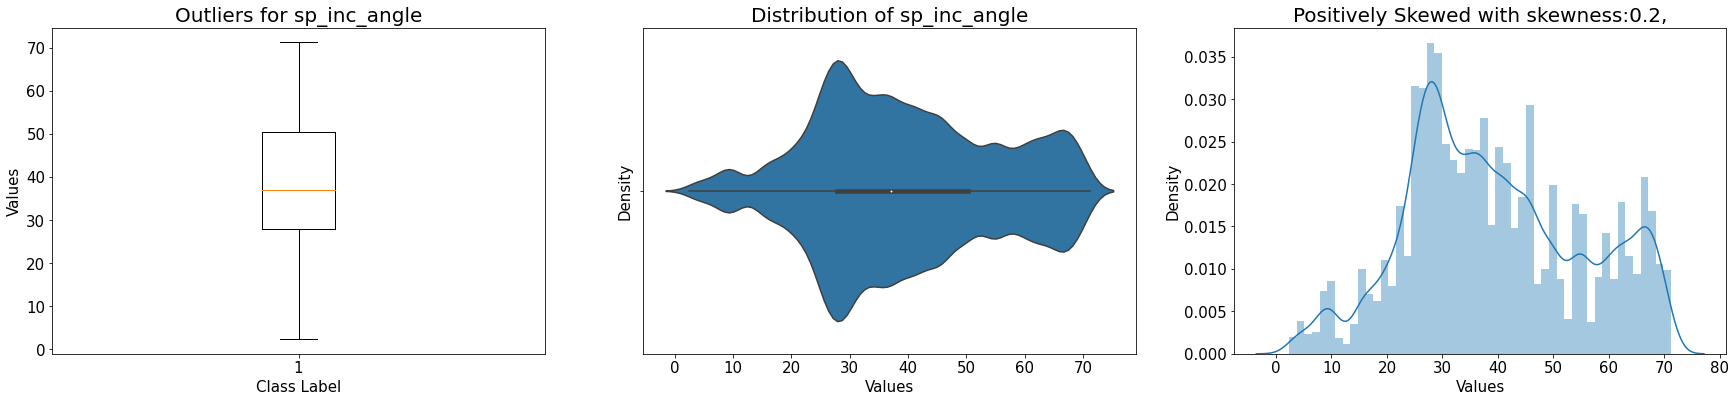

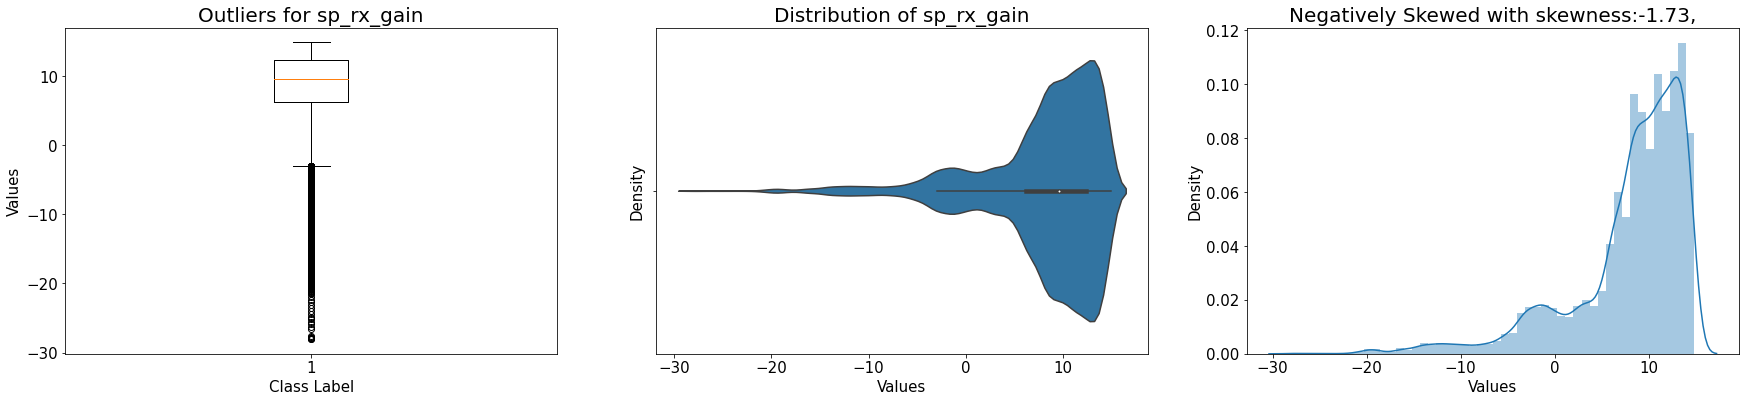

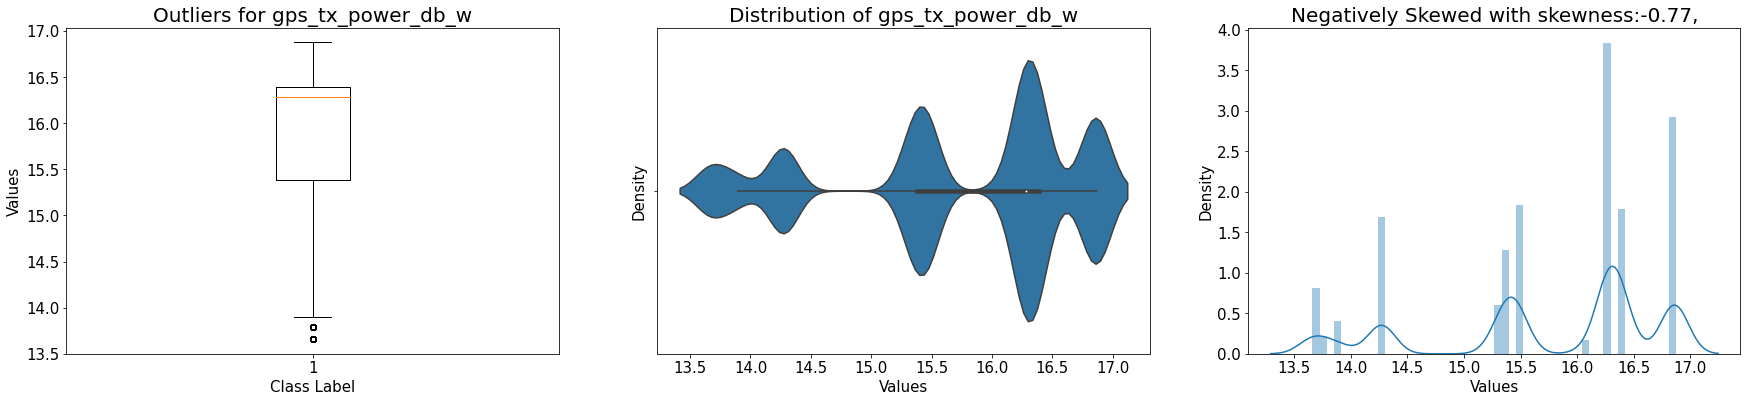

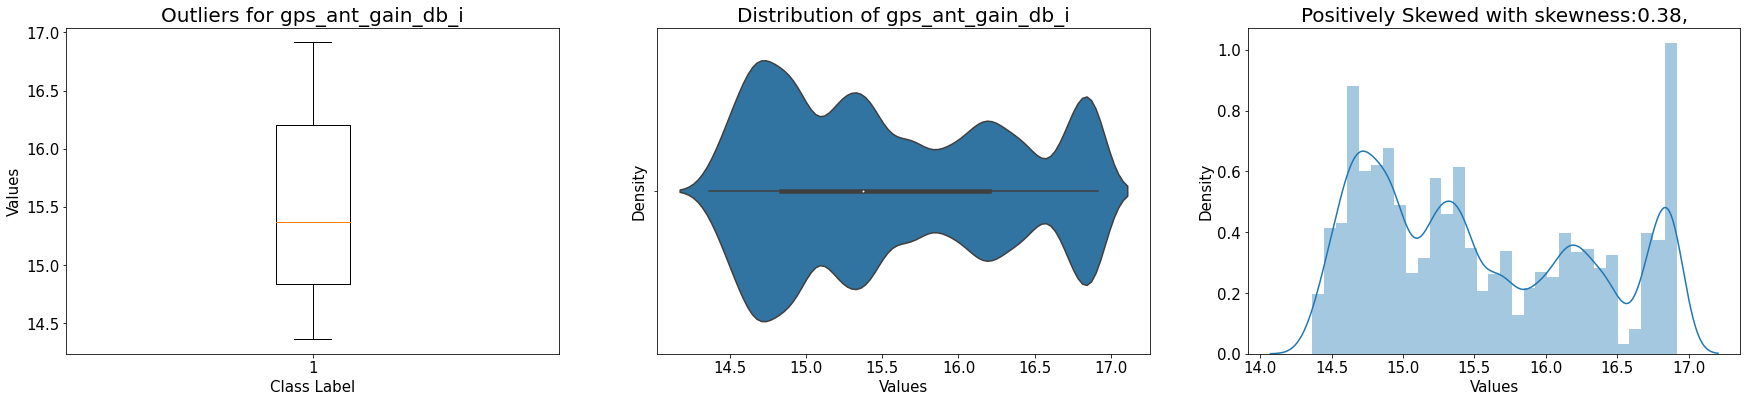

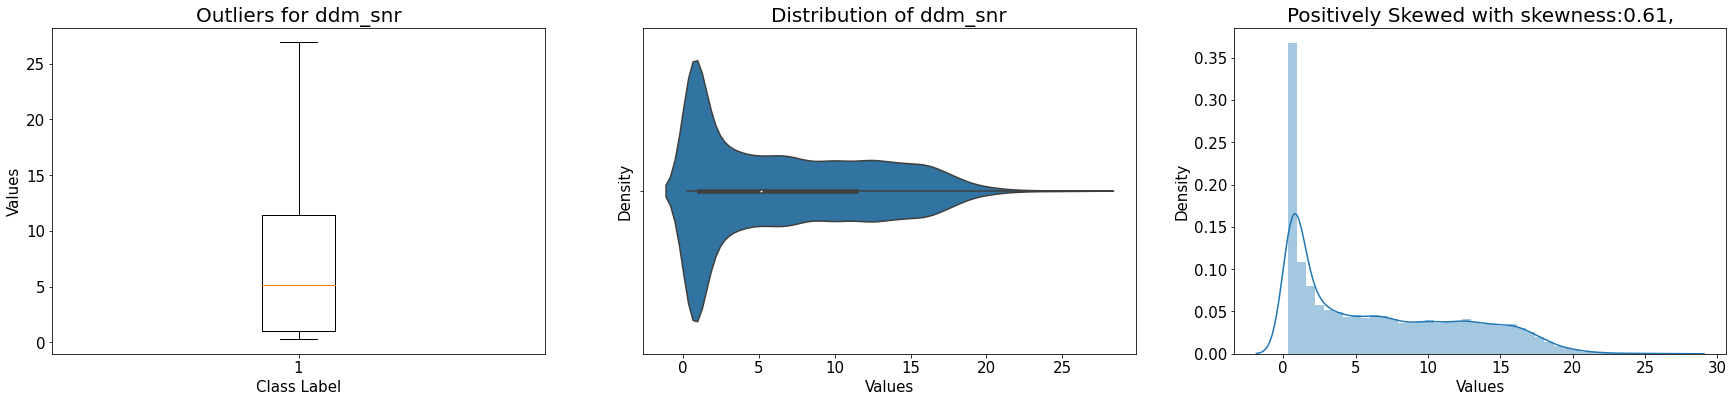

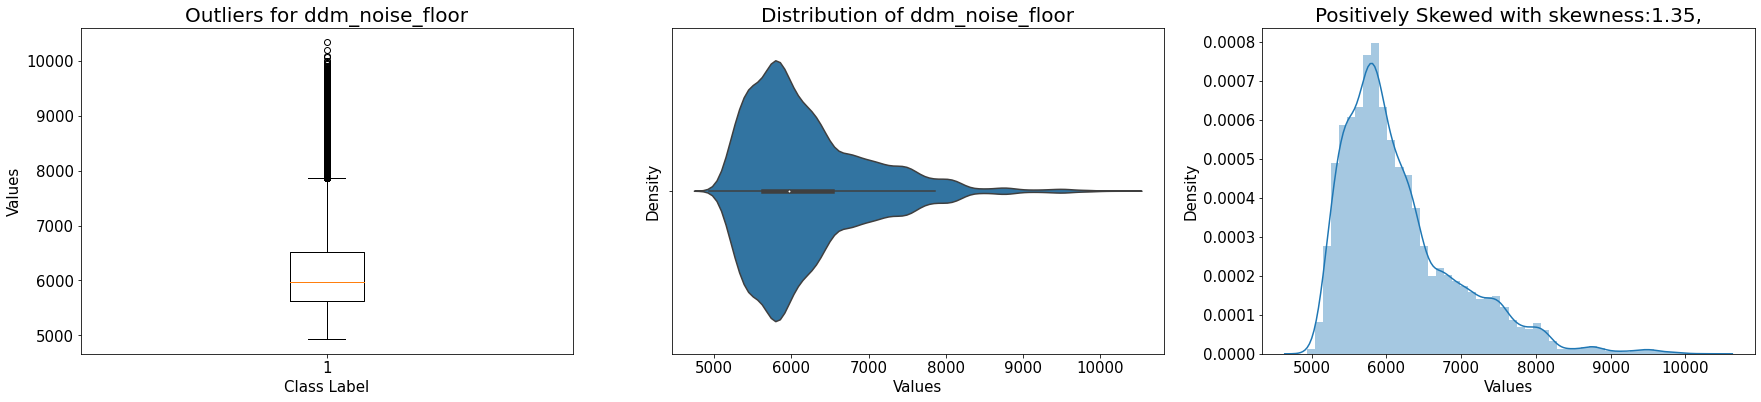

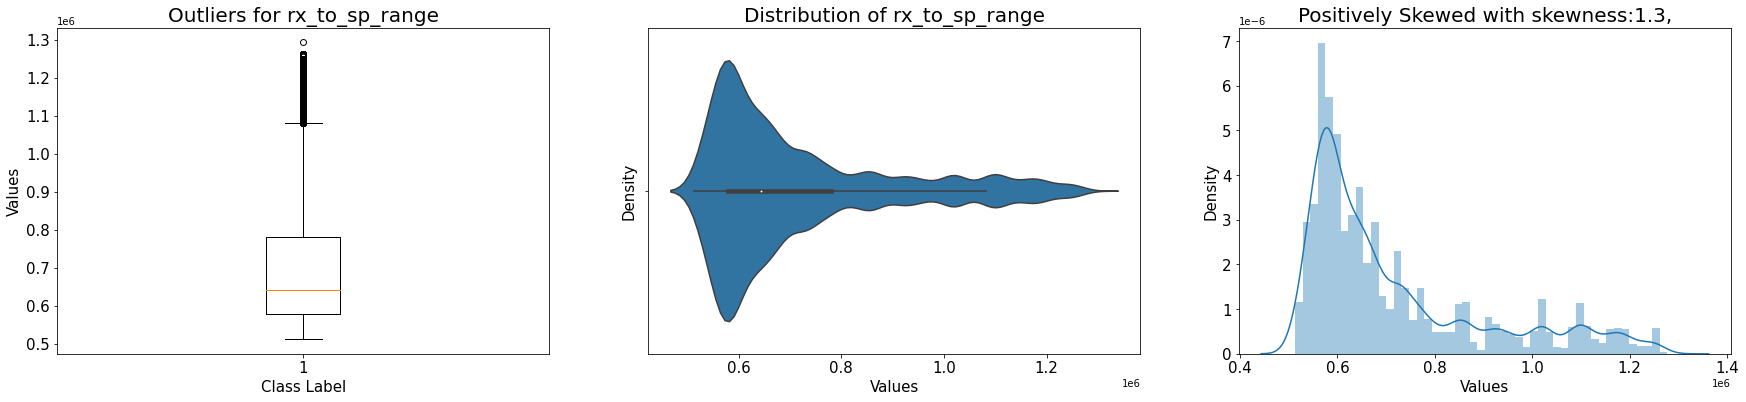

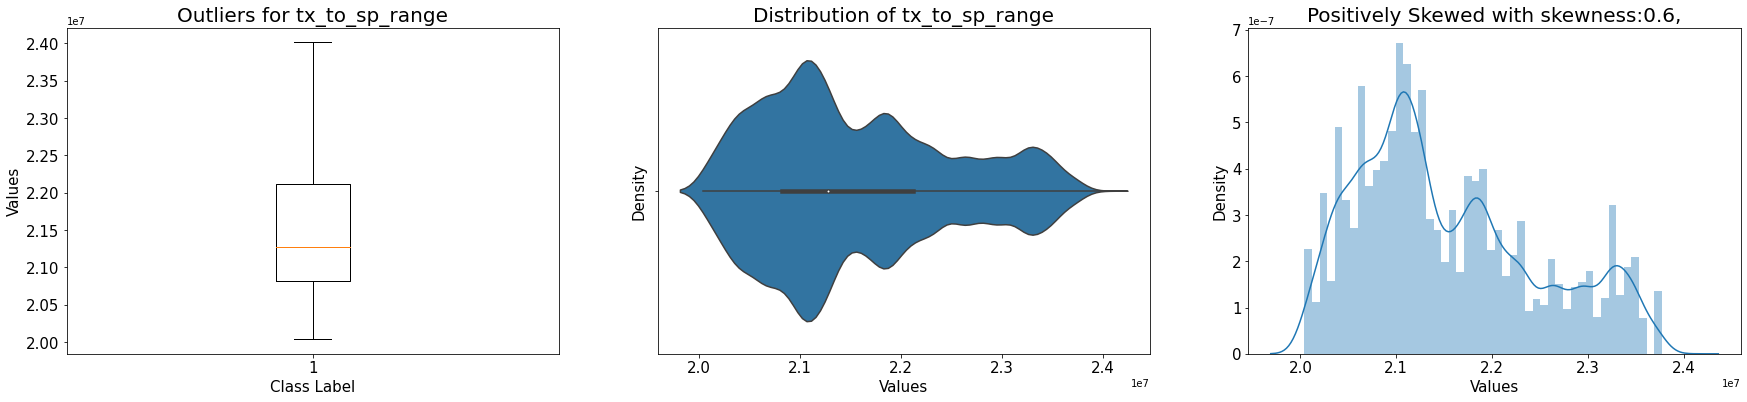

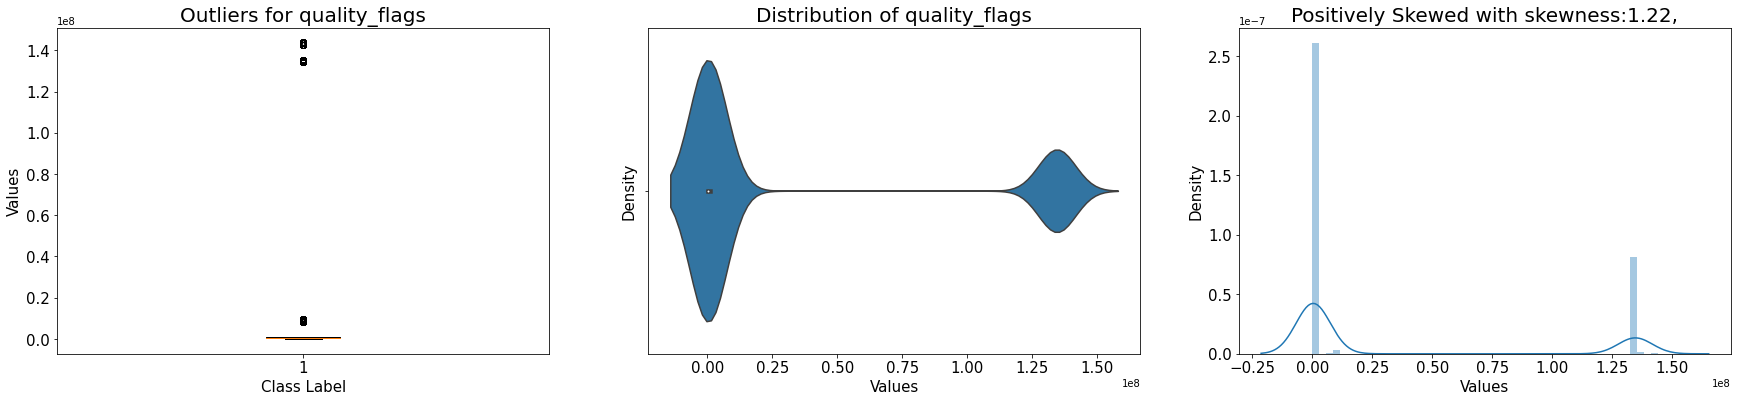

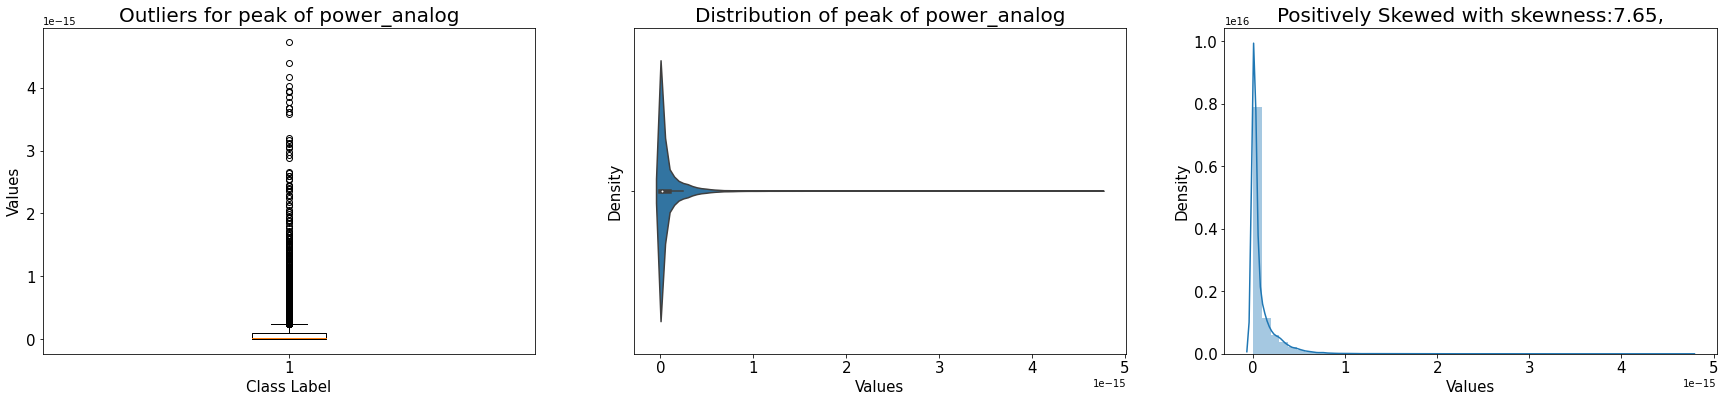

In [19]:
%%time
Var = Cygnss_csv1.keys()
print(f'Total Samples in Ganga Catchment on 01 Jan 2020 : {len(Cygnss_csv1)}')
for i in range(2,len(Var)):
    var = Var[i]
    Df  = (np.array(Cygnss_csv1[f'{var}']))
    Outlier_Detection(Df,f'{var}')

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Surface Reflectivity</p>

### Calculating effective Surface Reflectivity :
$${P_r} = \frac{{P_{r}^t}{G^t}{G^r}{\lambda^2}{T_{rl}}}{[4\pi(R_{ts}+R_{sr})]^2}......................(1)$$

It is then corrected for antenna gain, range and the GPS transmit power assuming a coherent reflection : ${Pr}$ 

+ **Providing all corrections we find the effective surface reflectivity ${T_{rl}}$ inverting the above formula :**
$${T_{rl}} = \frac{{[4\pi(R_{ts}+R_{sr})]^2}}{{G^t}{G^r}{P_{r}^t}{\lambda^2}}{P_r}.......................(2) $$

+ ${T_{rl}} = {P_{r_{eff}}}$, Effective Surface Reflectivity in dB  
+ ${{P_r}}  = {DDM_{peak}}$, The peak value of the analog DDM in W/m2
+ ${R_{ts}} = {P_5}$, Distance (m) specular point to the transmitter    
+ ${R_{sr}} = {P_6}$, Distance (m) specular point to the reciever
+ ${{P_{r}^t}} = {P_7}$, GPS transmitting power (RHCP Power in dB) 
+ ${{G^t}} = {P_3}$, Gain of the transmitting antenna (dBi : Decibel Isotropic)
+ ${{G^r}} = {P_4}$, Gain of the recieving antenna : (dBi)
+ ${\lambda} = {0.19}$ meter, wavelength of L1 frequency

### Taking DDM_SNR as Pr
+ In previous Research with CYGNSS data DDM_SNR were taken but noise floor itself is noisy data
+ So in order to improve the surface reflectivity I have taken it as DDM_Peak

In [20]:
import Spatial_Correlation_SRCYGNSS_SMAP
import imp
imp.reload(Spatial_Correlation_SRCYGNSS_SMAP)
import Spatial_Correlation_SRCYGNSS_SMAP as cor

In [21]:
Data = Cygnss_csv1
SR1  = cor.Surface_Reflectivity1(Data)                           #----------------------------------------------->>> Driver Code

### The peak of DDM as Pr

In [22]:
SR2 = cor.Surface_Reflectivity2(Data)
Data['SR_eff1'] = SR1
Data['SR_eff2'] = SR2
DF = Data.dropna()
DF1 = DF.reset_index(drop=True)
DF1

sp_lat     sp_lon  sp_inc_angle  sp_rx_gain  gps_tx_power_db_w  \
0      24.802496  73.007675     26.162573   14.247239             13.660   
1      24.816223  73.033970     26.168324   14.242600             13.660   
2      24.829940  73.060280     26.174116   14.238091             13.660   
3      24.843658  73.086590     26.179937   14.233192             13.660   
4      24.857365  73.112910     26.185799   14.227897             13.660   
...          ...        ...           ...         ...                ...   
27119  24.624582  83.625374     31.502832    0.226153             16.843   
27120  24.611542  83.651306     31.527088    0.130212             16.843   
27121  24.598505  83.677230     31.551338    0.083129             16.843   
27122  24.585463  83.703160     31.575610    0.168665             16.843   
27123  24.572424  83.729090     31.599880    0.045862             16.843   

       gps_ant_gain_db_i   ddm_snr  ddm_noise_floor  rx_to_sp_range  \
0              14.767239  8.522056        5468.6235        569248.0   
1              14.767685  8.977606        5442.3780        569283.0   
2              14.768134  8.468381        5427.3535        569316.0   
3              14.768586  7.131919        5450.5557        569351.0   
4              14.769041  7.496569        5421.6323        569384.0   
...                  ...       ...              ...             ...   
27119          15.327077  0.955599        6368.5680        612024.0   
27120          15.329511  0.661445        6237.7990        612168.0   
27121          15.331944  0.850339        6419.5700        612315.0   
27122          15.334382  0.839907        6250.3965        612459.0   
27123          15.336822  0.683170        6261.3564        612605.0   

       tx_to_sp_range  quality_flags  peak of power_analog       SR_eff1  \
0          20500764.0         269313          4.538676e-17  2.040583e+12   
1          20500976.0         269313          5.098621e-17  2.150282e+12   
2          20501191.0         269313          4.440568e-17  2.028886e+12   
3          20501406.0         269313          3.082364e-17  1.709215e+12   
4          20501623.0         269313          3.399072e-17  1.797213e+12   
...               ...            ...                   ...           ...   
27119      20894201.0        1055745          1.899029e-18  1.396837e+13   
27120      20895319.0         269313          1.243271e-18  1.679056e+13   
27121      20896438.0         269313          1.681519e-18  3.380687e+13   
27122      20897559.0         269313          1.615084e-18  1.645594e+13   
27123      20898680.0         269313          1.291994e-18  4.922022e+13   

         SR_eff2  
0       2.760152  
1       3.101667  
2       2.702187  
3       1.876322  
4       2.069866  
...          ...  
27119   5.922892  
27120   6.734462  
27121  14.266435  
27122   6.753362  
27123  19.867506  

[27124 rows x 14 columns]

Wall time: 670 ms


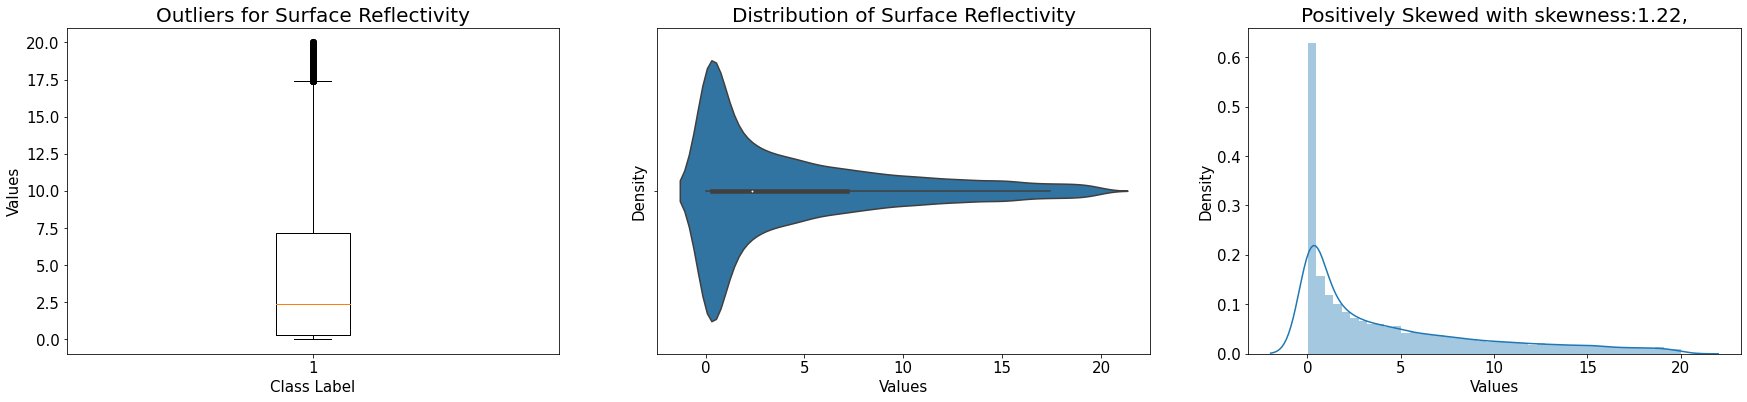

In [23]:
%%time
Cygnss_csv1          = pd.read_csv('D:\EG\Project Data\CYGNSS_CSV_Files\Day_001.csv')
peak_of_power_analog = Cygnss_csv1['peak of power_analog']
Data                 = Cygnss_csv1
SR2                  = cor.Surface_Reflectivity2(Data)
Data['SR_eff2']      = SR2
DF                   = Data.dropna()
DF1                  = DF.reset_index(drop=True)
CYGNSS_SR            = DF1['SR_eff2']
DF                   = pd.DataFrame(CYGNSS_SR)
Outlier_Detection(DF,'Surface Reflectivity')

+ 1. Observations with  SNR value < 2 dB 
+ 2. Observations with a Receiver Antenna gain value < 0 dB
+ 3. Observations with an Incidence angle > 40 degree

In [24]:
mask       = ((Cygnss_csv1['ddm_snr']>2) & (Cygnss_csv1['sp_rx_gain']>0) & (Cygnss_csv1['sp_inc_angle']<40))
Cygnss_csv = Cygnss_csv1[mask]

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Visualizing Soil Moisture Data of SMAP</p>

### Daily Visualization in AM and PM data

In [25]:
import SMAP_SM_Visualization
import imp
imp.reload(SMAP_SM_Visualization)
import SMAP_SM_Visualization as R2

In [26]:
%%time
#R2.SMAP_SM_Visualization_2020(1,1)

Wall time: 0 ns


### Daily Visualization after combining AM and PM data

+ For every week of the year

In [27]:
import SMAP_SM_Stacking
import imp
imp.reload(SMAP_SM_Stacking)
import SMAP_SM_Stacking as ST

In [28]:
# %%time
# for j in range(1,2):
#     for i in range(1,2):
#         ST.Daily_SM(ST.Month_No(j),i)

### Weekly Visualization after averaging

In [29]:
# %%time
# for j in range(1,2):
#     for i in range(1,2):
#         ST.Weekly_Avg_SM(ST.Month_No(j),i)

### Weekly Visualization after stacking

In [30]:
# %%time
# for j in range(1,2):
#     for i in range(1,2):
#         ST.Weekly_Stack_SM(ST.Month_No(j),i)

<a id="1"></a>
## <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;">Visualizing SM of ESA CCI</p>

In [31]:
import ESACCI_Stacking
import imp
imp.reload(ESACCI_Stacking)
import ESACCI_Stacking as ST1

### Daily Visualization

In [32]:
# %%time
# for j in range(1,2):
#     for i in range(1,5):
#         ST1.Daily_SM(ST1.Month_No(j),i)
# ST1.Daily_SM(ST1.Month_No(1),1)

### Weekly visualization after averaging

In [33]:
%%time
# for j in range(1,2):
#     for i in range(1,5):
#         ST1.Weekly_avg_SM(ST1.Month_No(j),i)
# ST1.Weekly_avg_SM(ST1.Month_No(1),1)

Wall time: 0 ns


### Weekly visualization after stacking

In [35]:
%%time
# for j in range(1,2):
#     for i in range(1,5):
#         ST1.Weekly_stacking_SM(ST1.Month_No(j),i)
# ST1.Weekly_stacking_SM(ST1.Month_No(1),1)

Wall time: 0 ns


### High temporal resolution
+ SMAP and ESA CCI Soil Moisture data has temporal resolution of 3-4 days
+ But in 3-4 days also there are gaps in the data
+ If we are taking 7 days data to get the soil moisture at each and every point 
+ Then temporal resolution will be get disturbed
+ In that case we can not use this data in real time project

### Spatial resolution
+ Also the single pixel is within 36x36 Km resolution, hence data is of poor resolution
+ It is useless for the agricultural point of view.

<a id="1"></a>
# <p style="background-color:#682F2F;font-family:newtimeroman;color:#FFF9ED;font-size:150%;text-align:center;border-radius:10px 10px;"> Correlation of SR with SM </p>

# Spatial correlation with daily data

### Spatial Interpolation method : nearest

In [36]:
%%time
cor.CYGNSS_SR_SMAP_SM_Corr(247,250,'nearest')

03 Sept 2020 Correlation = 69.18 %
04 Sept 2020 Correlation = 56.2 %
05 Sept 2020 Correlation = 42.31 %
06 Sept 2020 Correlation = 67.72 %
Wall time: 2.27 s


+ More than 69 % correlation can be seen
+ But **Nearest Method** is not good technique because it repeats the neighbour pixel values
+ Suppose at point P1 there is water and at point P1 no surface reflectivity available and we are trying to interpolate nearest land surface reflectivty values on this point P1
+ P1 will be treated as land according to the surface reflectivty values which is wrong

### Spatial Interpolation method : cubic

In [37]:
%%time
cor.CYGNSS_SR_SMAP_SM_Corr(247,250,'cubic')

03 Sept 2020 Correlation = 43.62 %
04 Sept 2020 Correlation = 32.07 %
05 Sept 2020 Correlation = 16.51 %
06 Sept 2020 Correlation = 30.23 %
Wall time: 1.72 s


+ Maximum 43 % correlation is found

### Comments:
+ Correlation is down because when using the interpolation technique griddata we are losing the surface reflectivity values on new SMAP grid point
+ So we are getting very few values for the correlation purpose

## Spatial correlation with weekly averaged and stacked data

### Daily data

In [38]:
import Stacking_CYGNSS_SR
import imp
imp.reload(Stacking_CYGNSS_SR)
import Stacking_CYGNSS_SR as Cor2

Wall time: 4.48 s


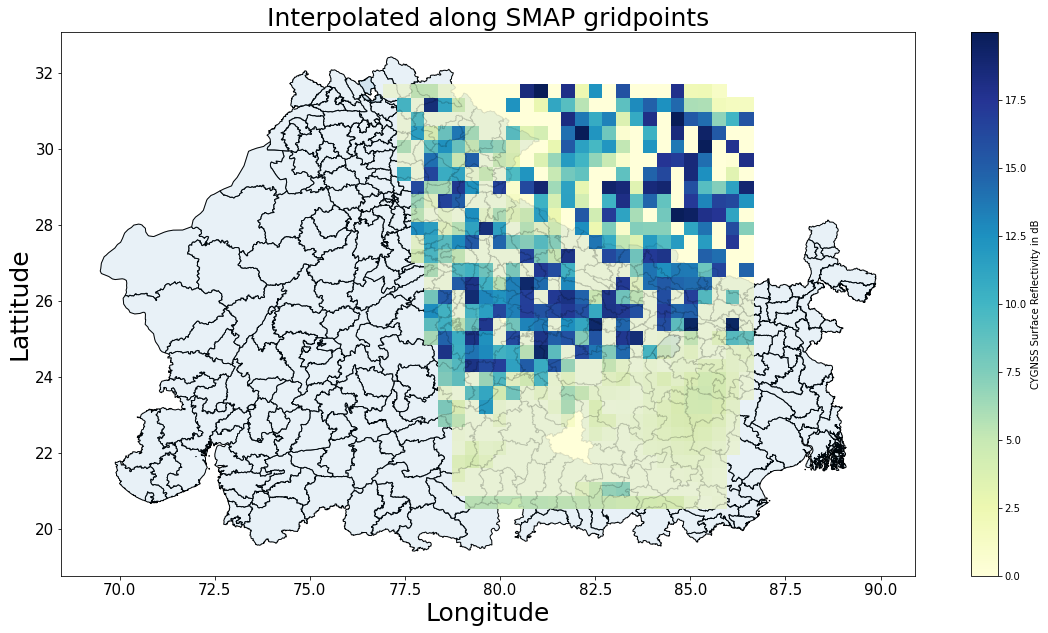

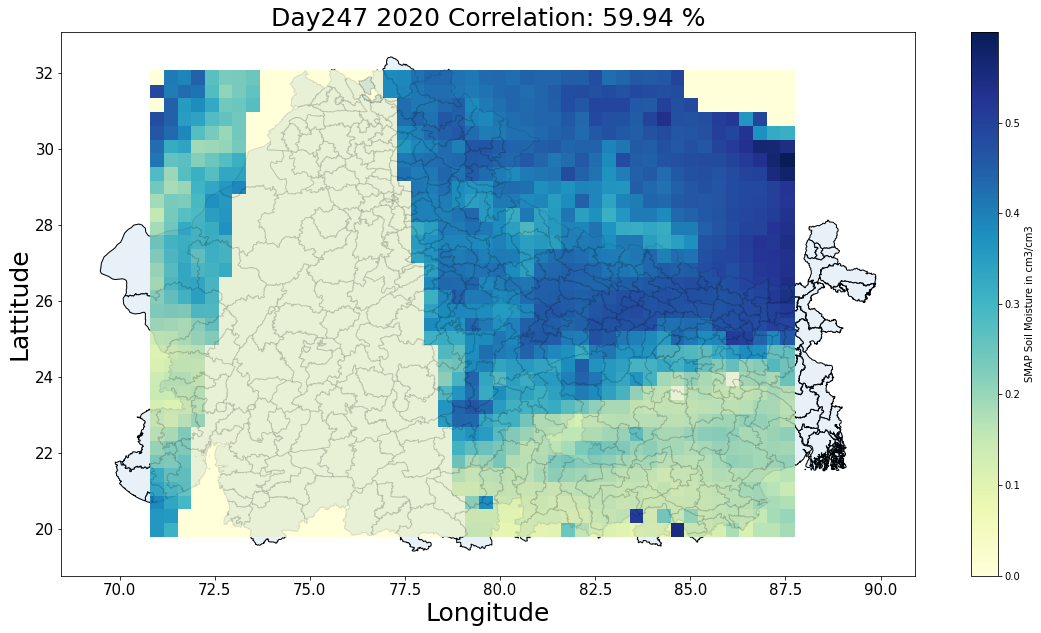

<Figure size 144x144 with 0 Axes>

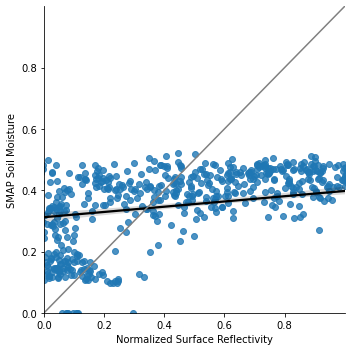

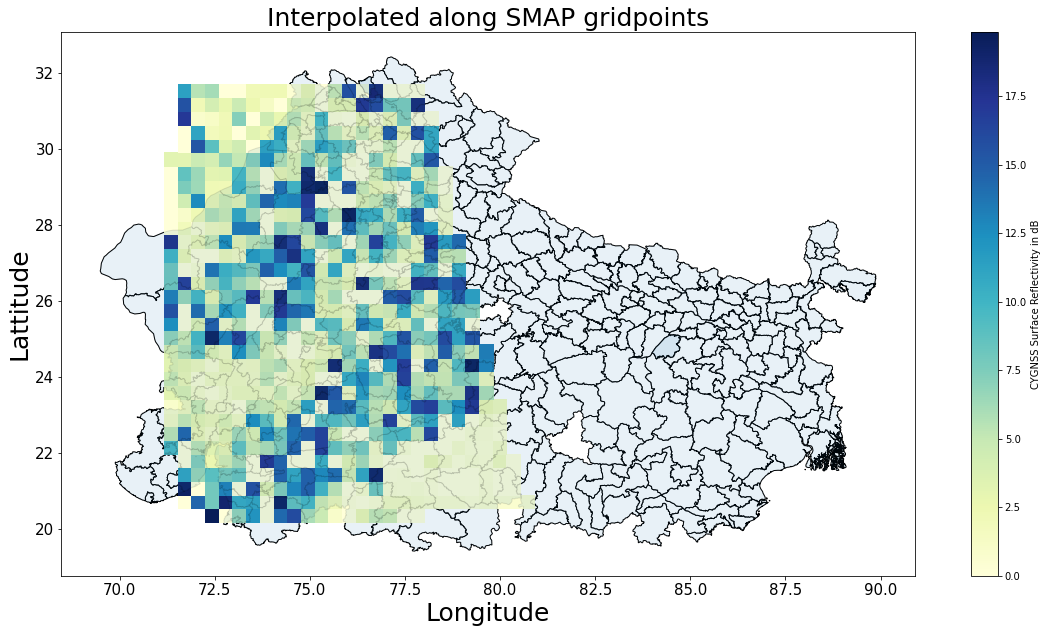

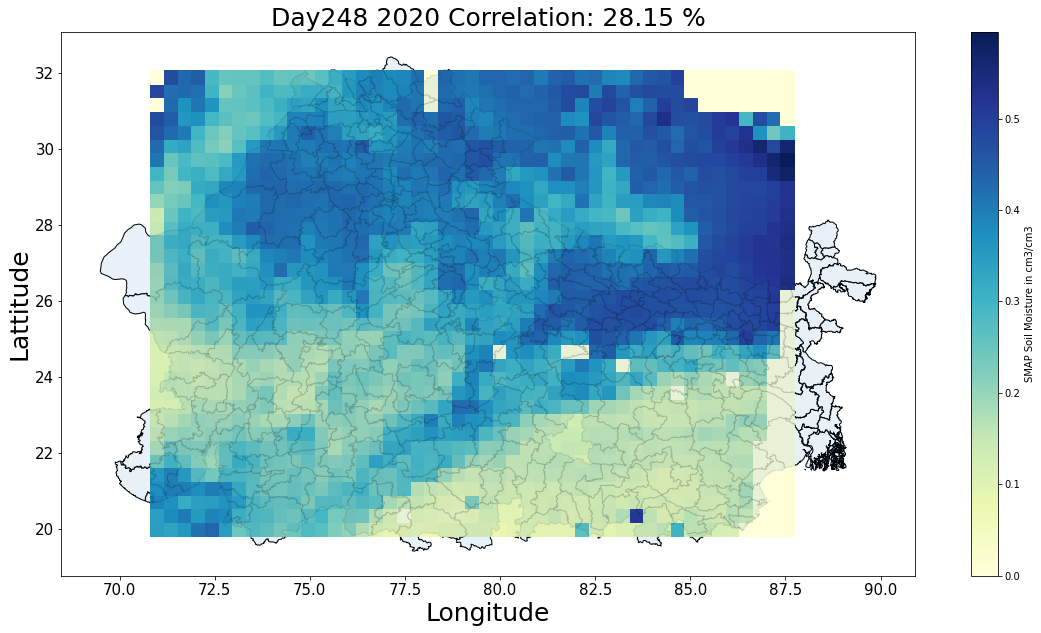

<Figure size 144x144 with 0 Axes>

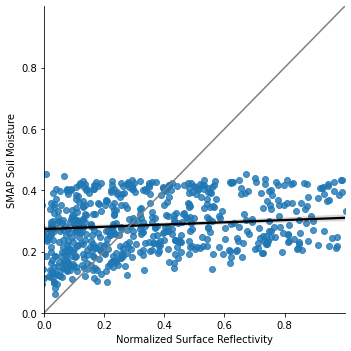

In [39]:
%%time
Cor2.Correlating_SM_SR(247,248)

### Weekly stacked data

Wall time: 2.25 s


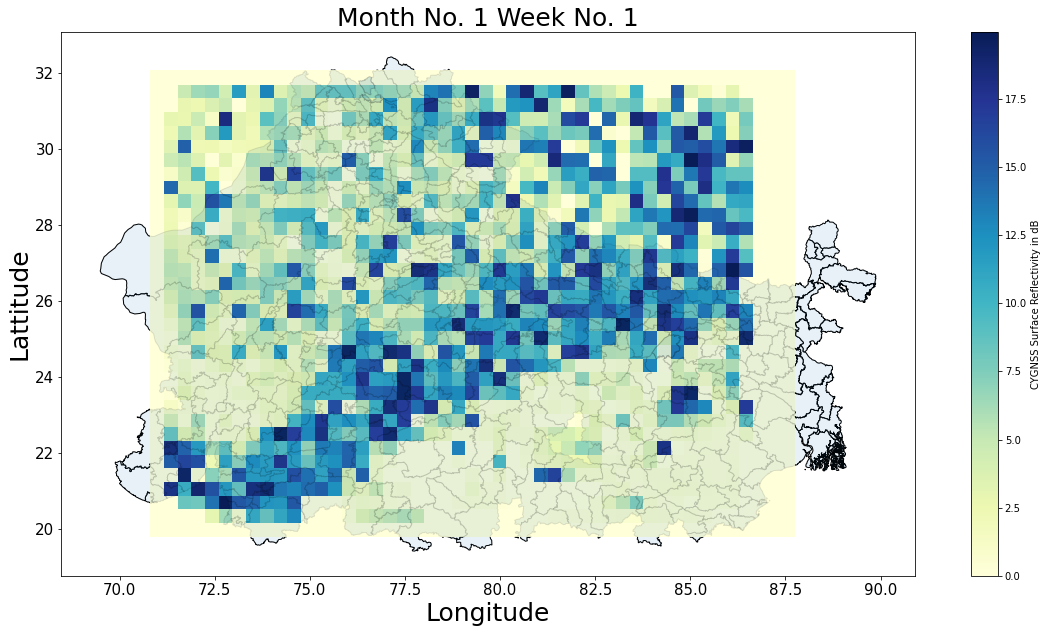

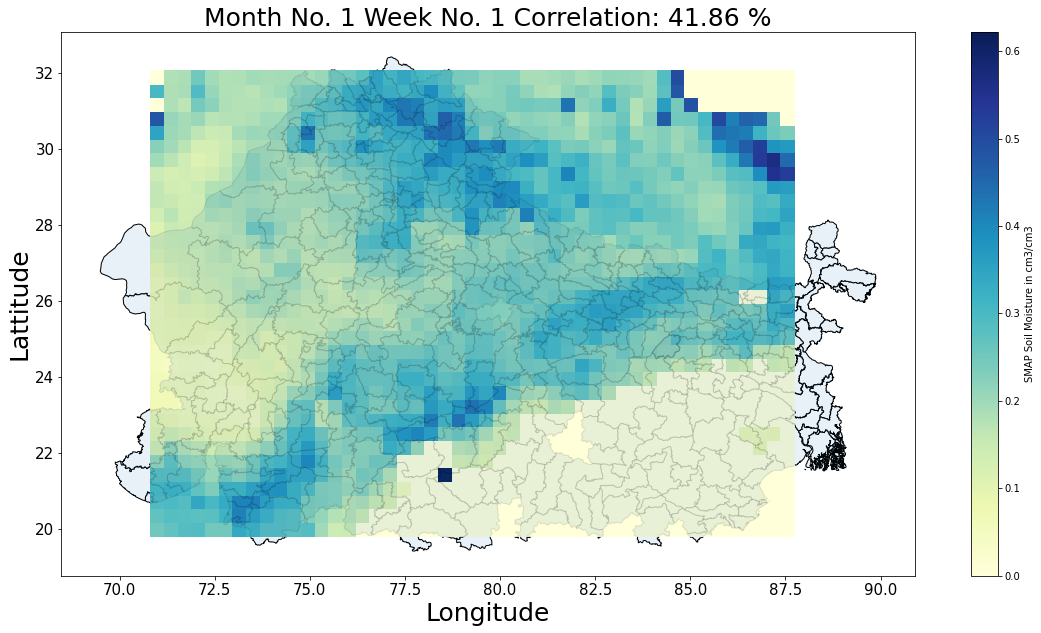

<Figure size 144x144 with 0 Axes>

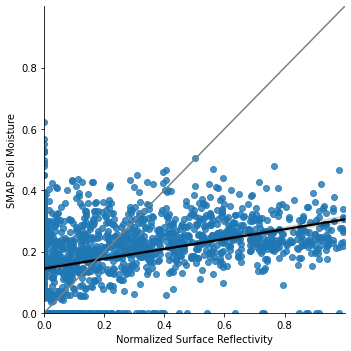

In [40]:
%%time
# for j in range(8,9):
#     for i in range(1,5):
#         Cor2.Weekly_Stacking_SM(j,i)
Cor2.Weekly_Stacking_SM(1,1)

### Weekly average data

Wall time: 2.06 s


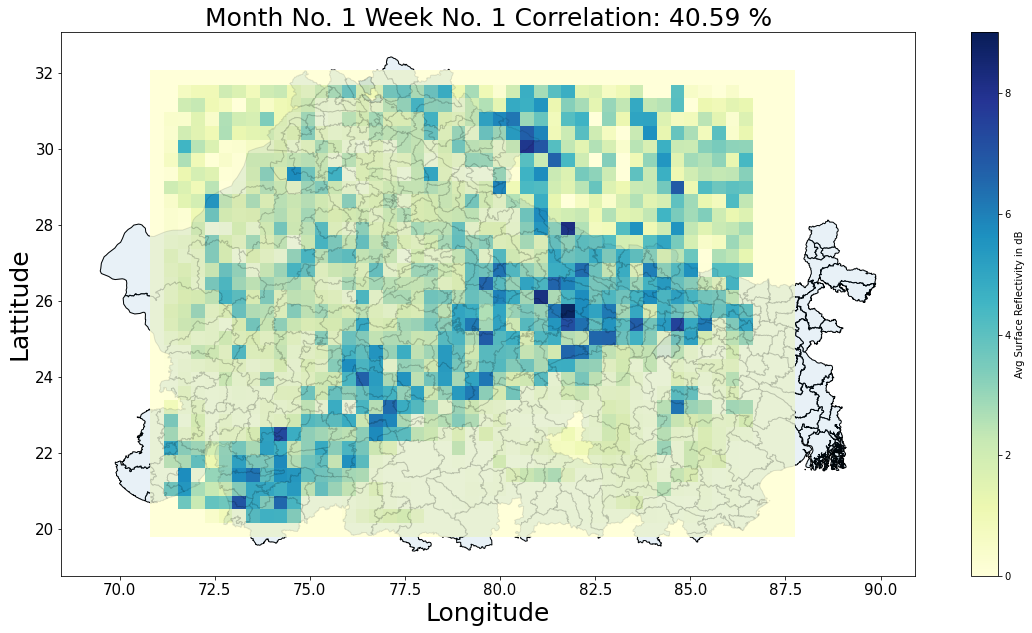

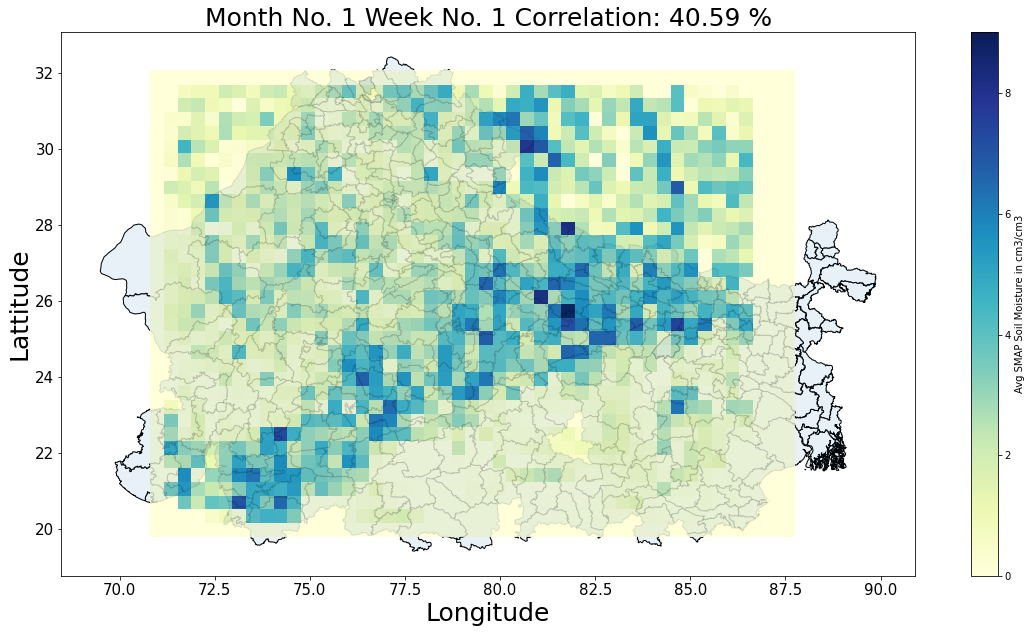

<Figure size 144x144 with 0 Axes>

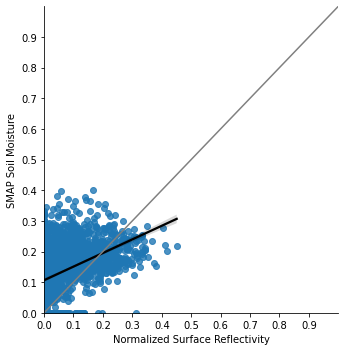

In [41]:
%%time
# for j in range(8,9):
#     for i in range(1,5):
#         Cor2.WeeklyAvg_SM(j,i)
Cor2.WeeklyAvg_SM(1,1)

### Ignoring the interpolation technique
1. Original Value Compared without any interpolation
2. Taking average within each pixel point of SMAP within the Ganga Catchment region

In [42]:
import Correlation_By_Averaging_Values
import imp
imp.reload(Correlation_By_Averaging_Values)
import Correlation_By_Averaging_Values as TempC

Wall time: 8.67 s


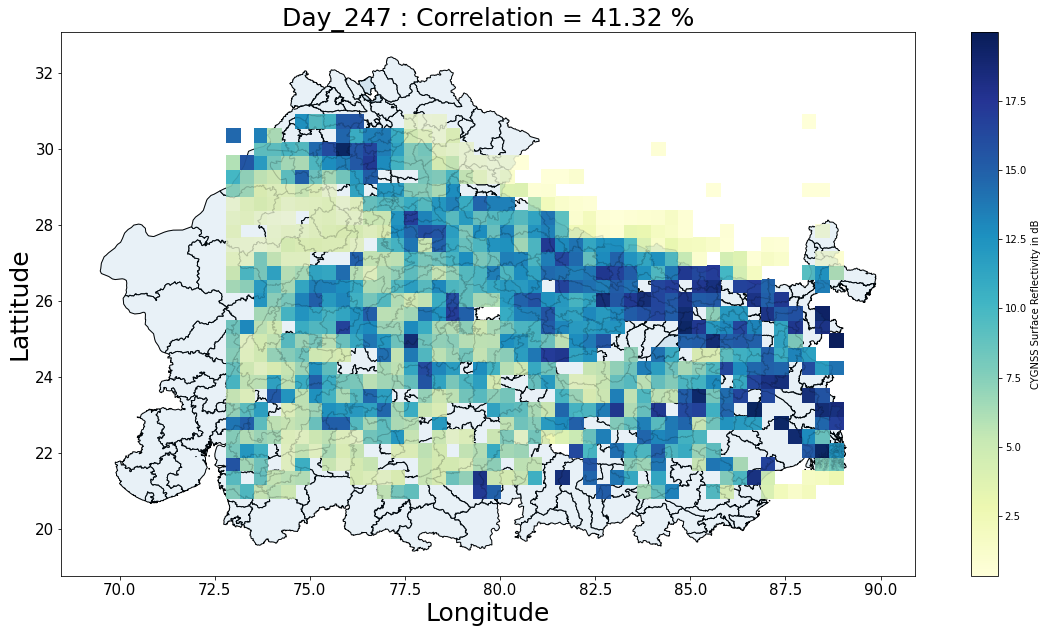

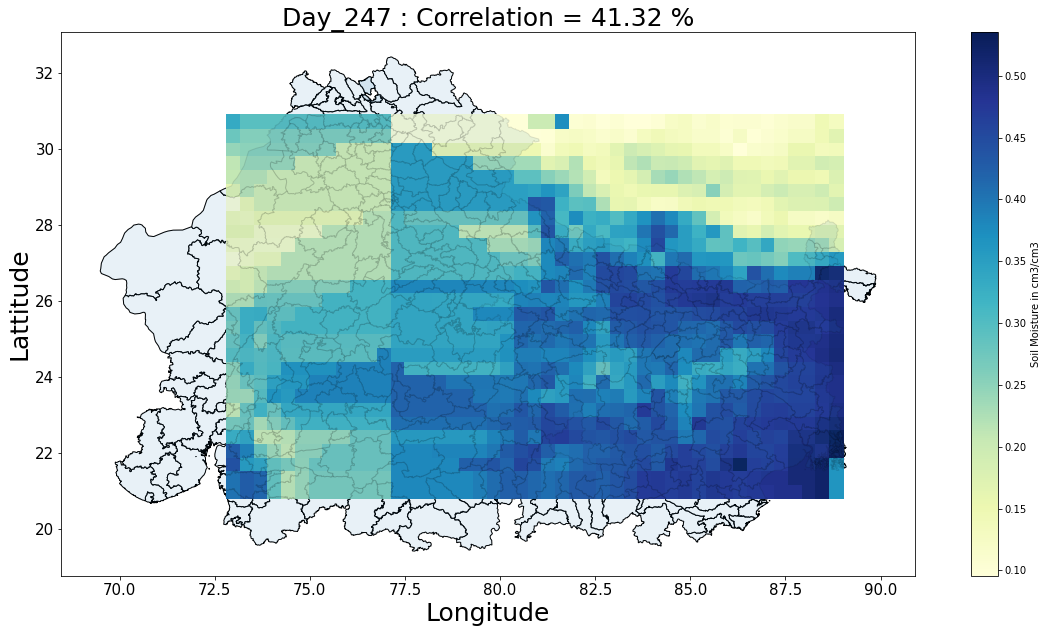

<Figure size 144x144 with 0 Axes>

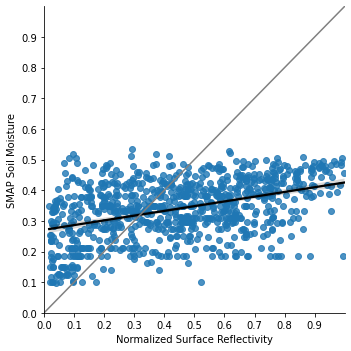

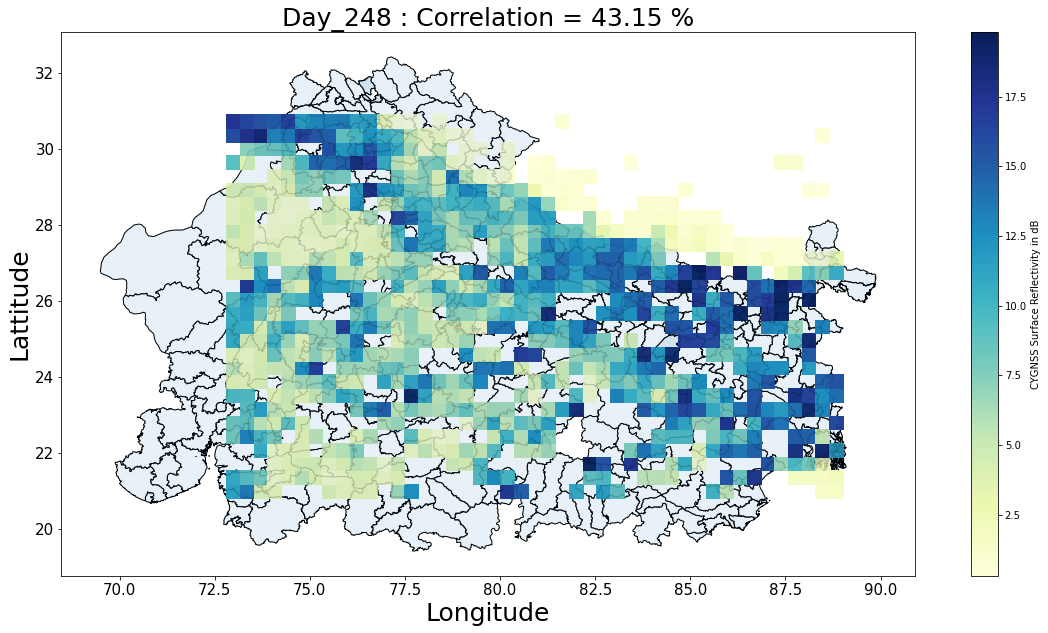

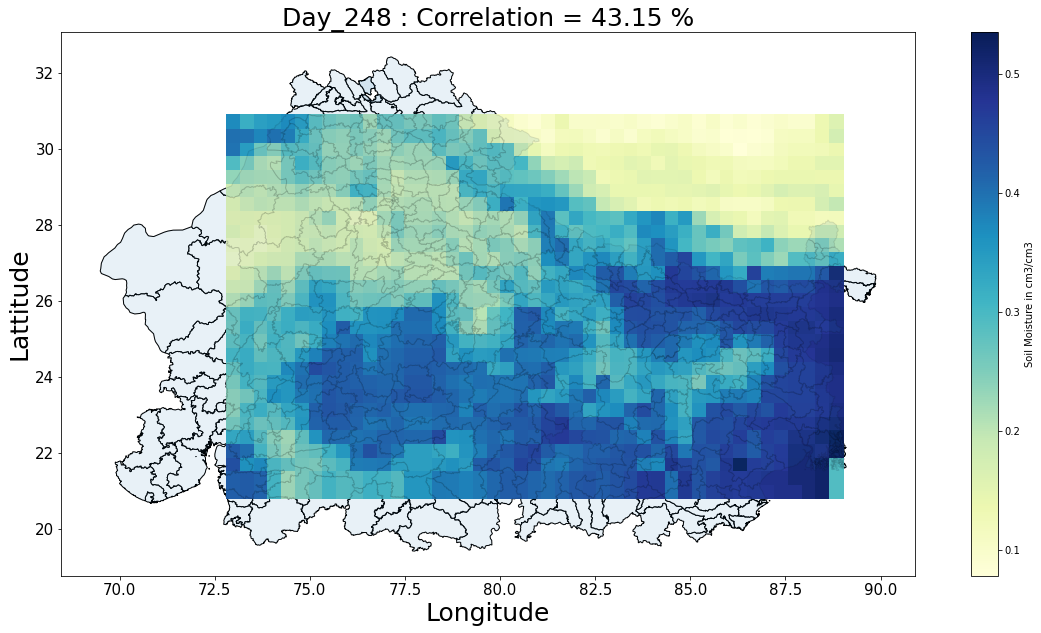

<Figure size 144x144 with 0 Axes>

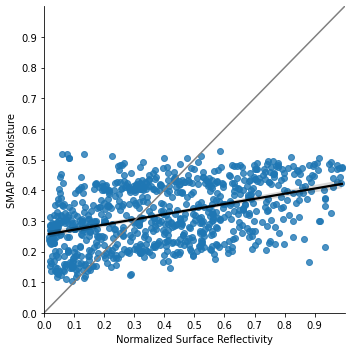

In [43]:
%%time
TempC.Corr_SM_SMAP_CYGNSS(247,248)

+ We can see that the improvements in spatial correlation values averaging surface reflectivity within SMAP grid
+ Maximum we get 64 % correlation

### Temporal correlation between SMAP Soil Moisture and CYGNSS Surface Reflectivity 

In [44]:
import Temporal_Correlation_SR_SM
import imp
imp.reload(Temporal_Correlation_SR_SM)
import Temporal_Correlation_SR_SM as SC

+ Downloading the csv files for single location in the Catchment containing the temporal SMAP SM and CYGNSS SR of 366 days

In [45]:
# lat = [22.18,22.54,22.9,23.26,23.62,23.98,24.34,24.7,25.06,25.42,25.78,26.14,26.5,26.86] 
# lon = [73.18,73.54,73.9,74.26,74.98,75.34,75.7,76.06,76.42,76.78,77.14,77.5,77.86,78.22,78.58,78.94]
# for i in range(len(lat)):
#     lat1 = lat[i]
#     for j in range(len(lon)):
#         lon1 = lon[j]
#         SC.CYGNSS_SMAP_Data_availability(1,366,lat1,lon1)

### With band as standard deviation

Wall time: 176 ms


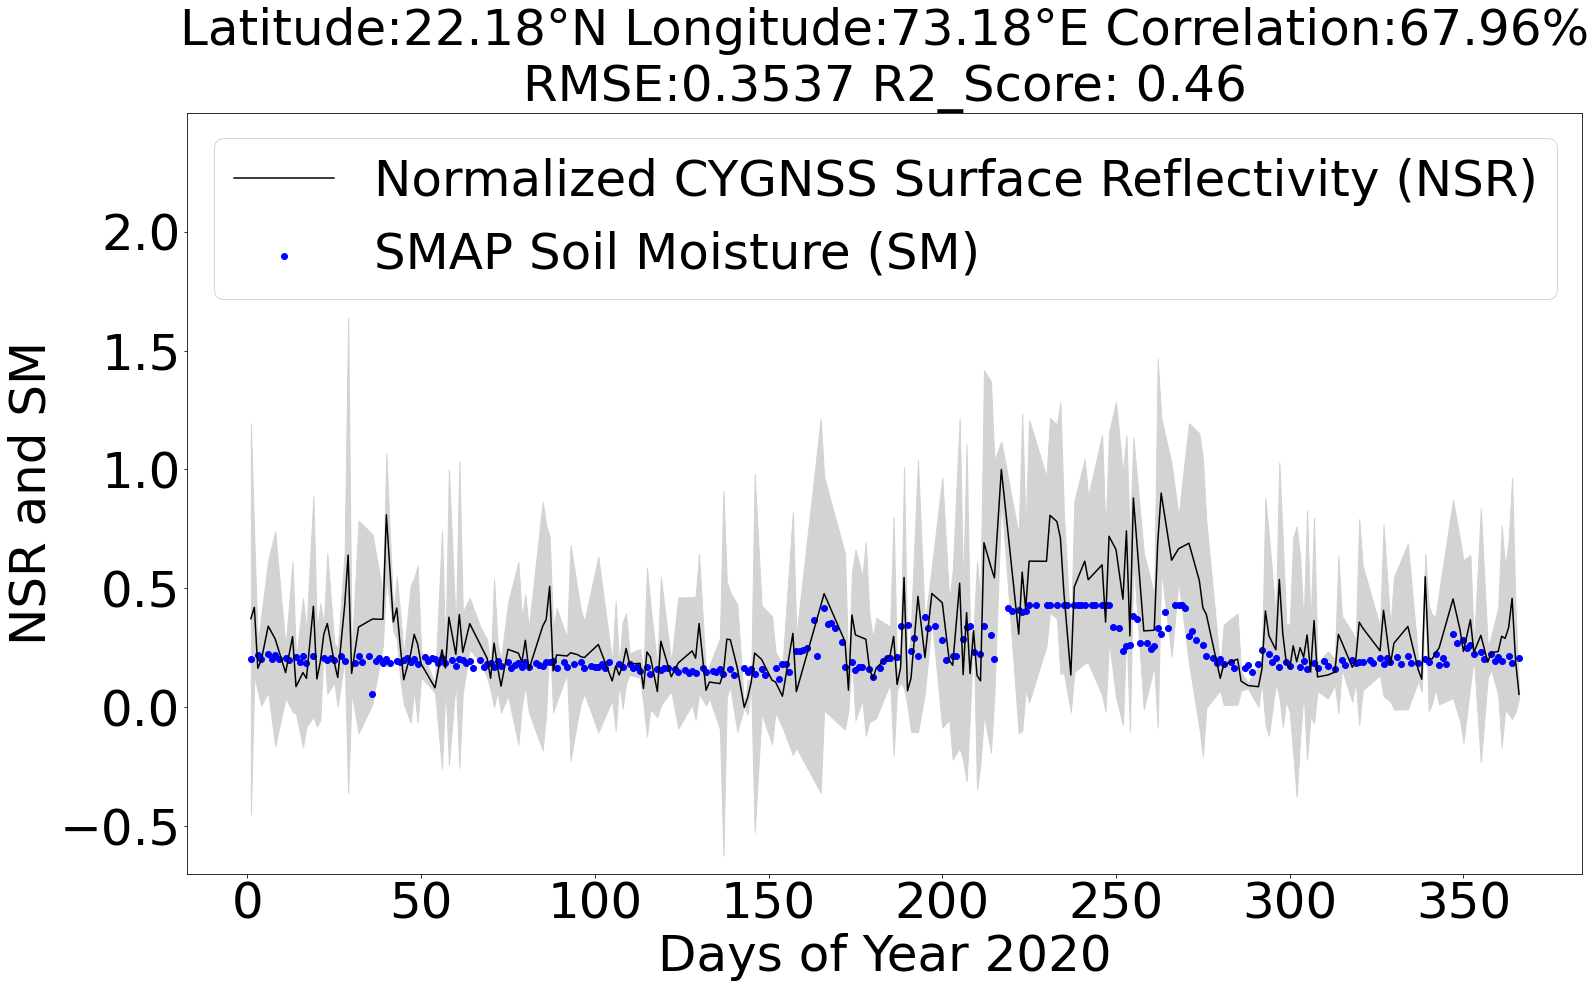

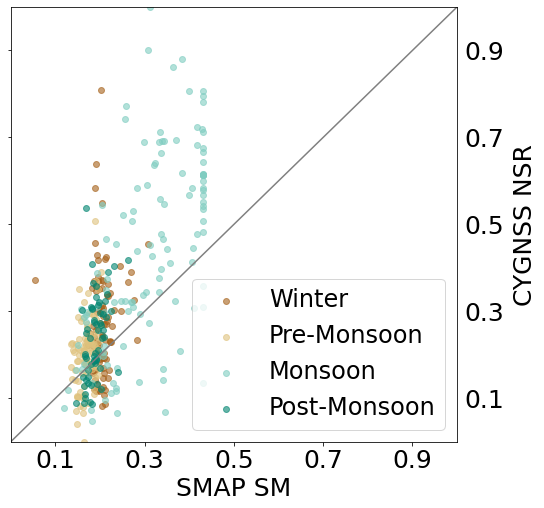

In [46]:
%%time
lat = [22.18]#,22.54,22.9,23.26,23.62,23.98,24.34,24.7,25.06,25.42,25.78,26.14,26.5,26.86] 
lon = [73.18]#,73.54,73.9,74.26,74.98,75.34,75.7,76.06,76.42,76.78,77.14,77.5,77.86,78.22,78.58,78.94]
for i in range(len(lat)):
    lat1 = lat[i]
    for j in range(len(lon)):
        lon1 = lon[j]
        SC.Plotting_Variations_with_band(lat1,lon1)

Wall time: 369 ms


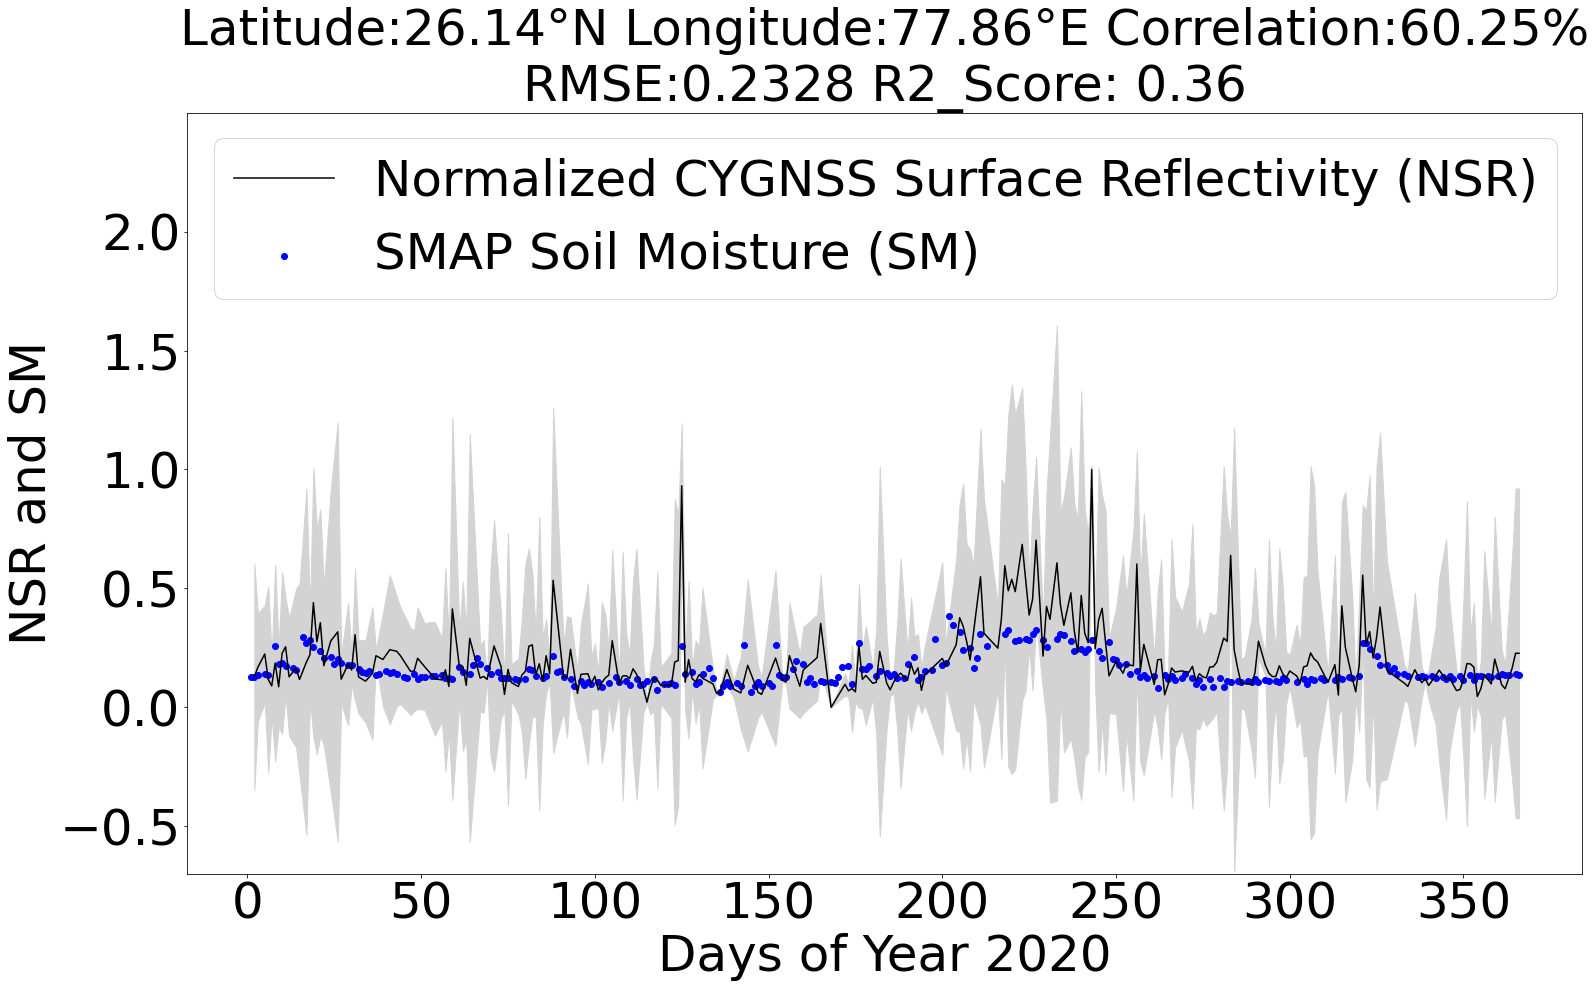

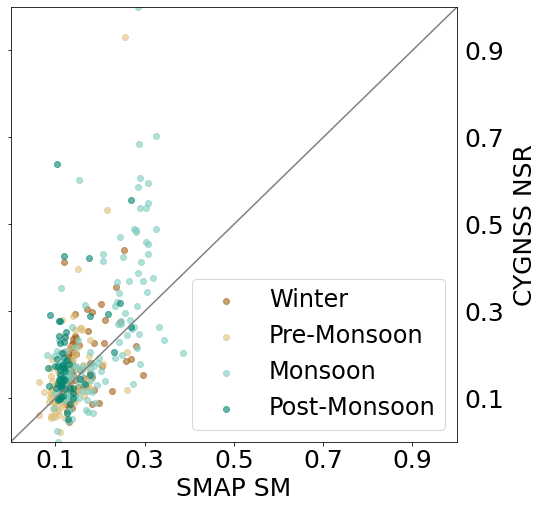

In [47]:
%%time
lat = [26.14] 
lon = [77.86]
for i in range(len(lat)):
    lat1 = lat[i]
    for j in range(len(lon)):
        lon1 = lon[j]
        SC.Plotting_Variations_with_band(lat1,lon1)

Wall time: 172 ms


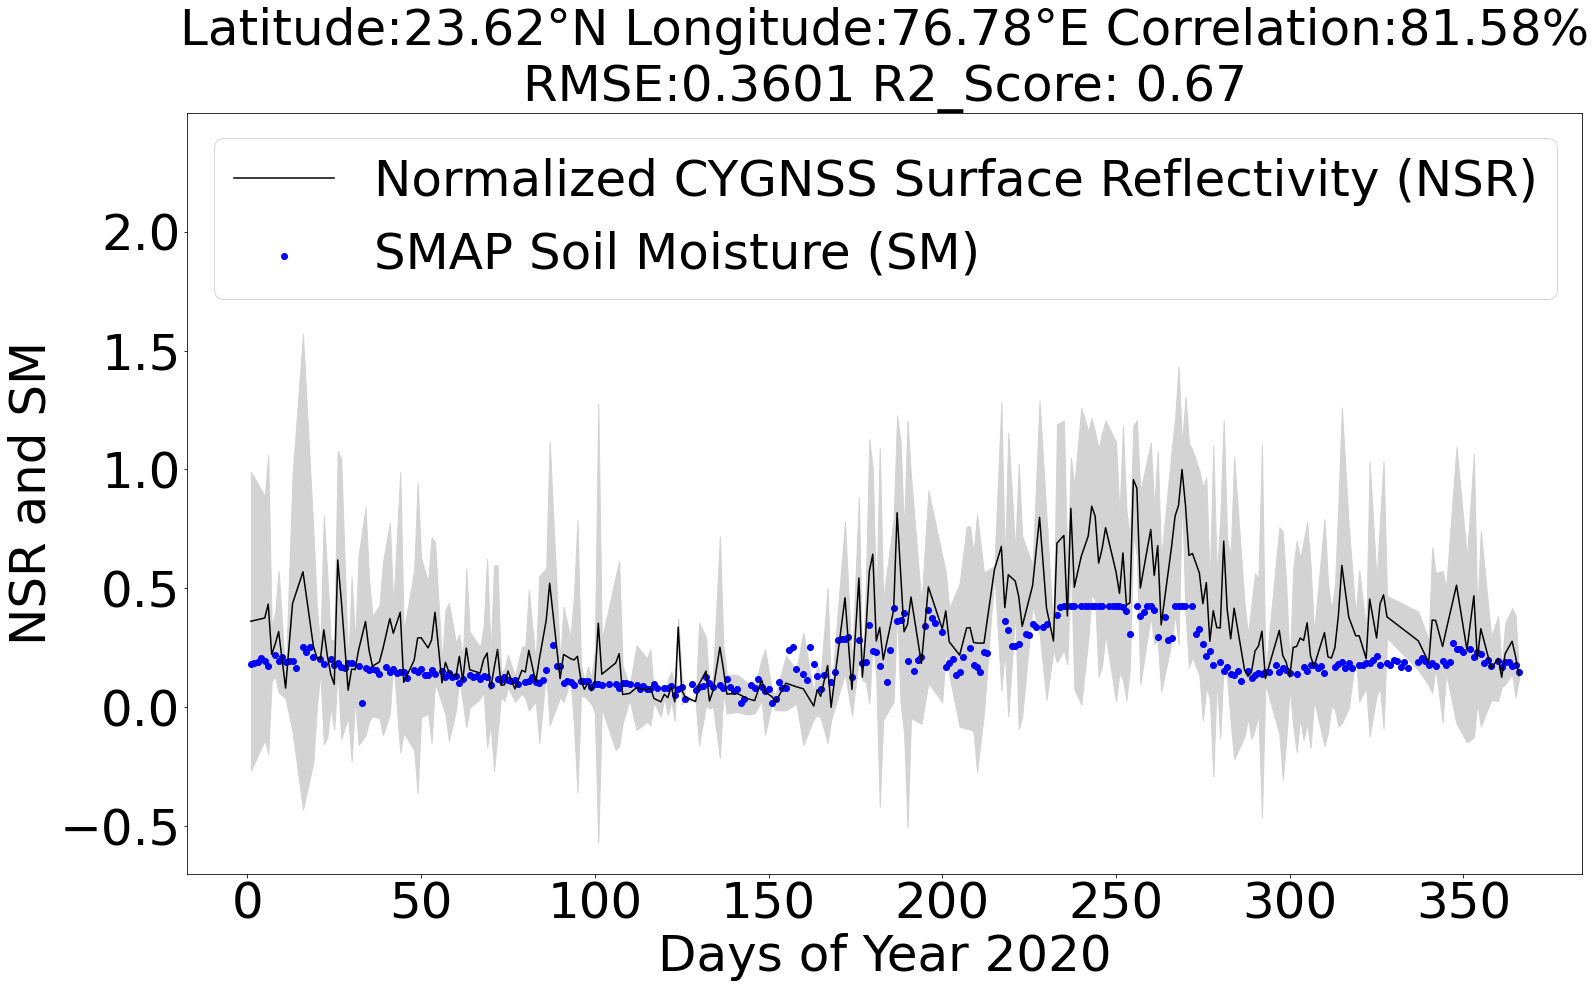

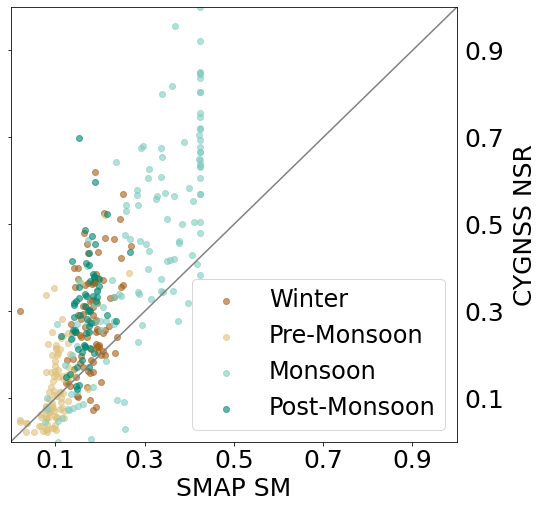

In [48]:
%%time
lat = [23.62] 
lon = [76.78]
for i in range(len(lat)):
    lat1 = lat[i]
    for j in range(len(lon)):
        lon1 = lon[j]
        SC.Plotting_Variations_with_band(lat1,lon1)

### Simple correlation without any band

Wall time: 975 ms


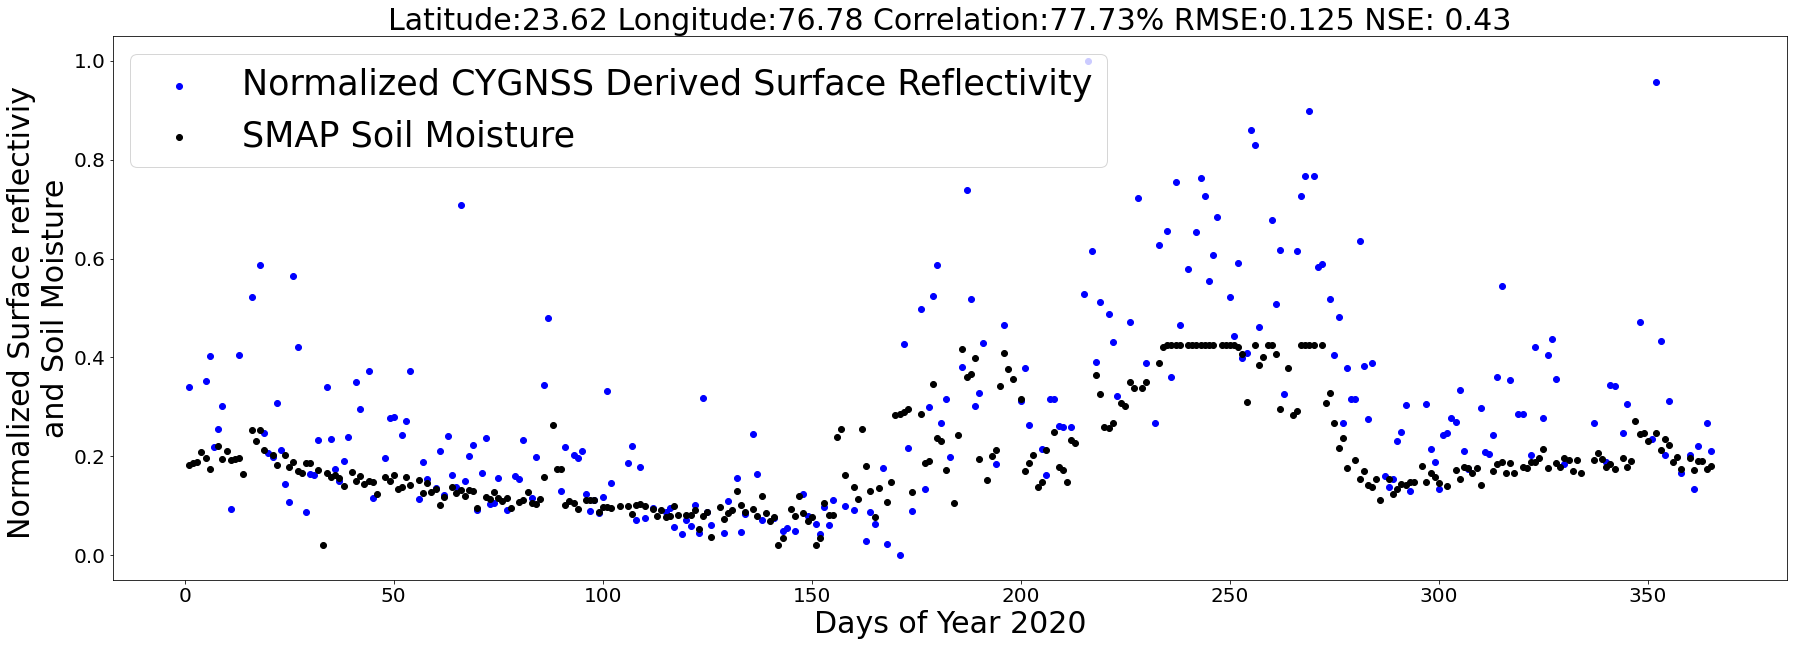

<Figure size 144x144 with 0 Axes>

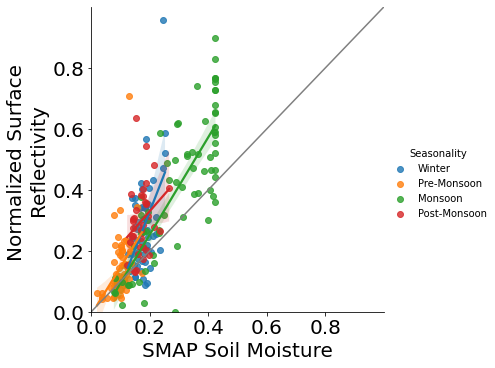

In [49]:
%%time
lat = [23.62] 
lon = [76.78]
for i in range(len(lat)):
    lat1 = lat[i]
    for j in range(len(lon)):
        lon1 = lon[j]
        SC.Plotting_Variations(lat1,lon1)

# Temporal Correlation with GLDAS SM Data

In [50]:
import Regridding_CYGNSS_SR_GLDAS_SM_Grids
import imp
imp.reload(Regridding_CYGNSS_SR_GLDAS_SM_Grids)
import Regridding_CYGNSS_SR_GLDAS_SM_Grids as R_1

In [51]:
# lat = [22.18]
# lon = [73.9]
# for i in range(len(lat)):
#     lat1 = lat[i]
#     for j in range(len(lon)):
#         lon1 = lon[j]
#         R_1.CYGNSS_GLDAS_Data_availability(1,365,lat1,lon1)

In [52]:
import Correlating_SR_with_GLDAS_SM
import imp
imp.reload(Correlating_SR_with_GLDAS_SM)
import Correlating_SR_with_GLDAS_SM as R1

Wall time: 534 ms


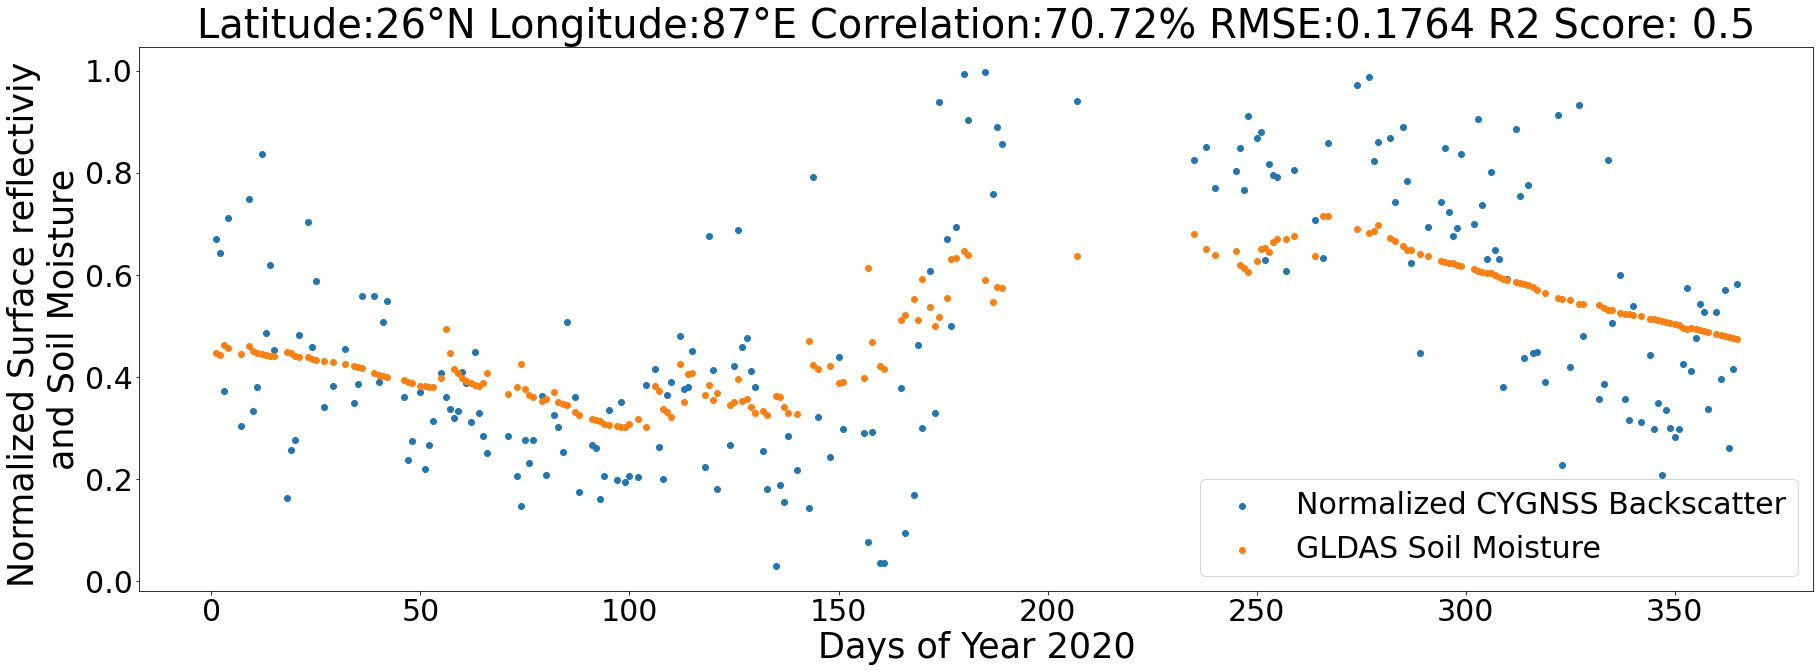

<Figure size 576x576 with 0 Axes>

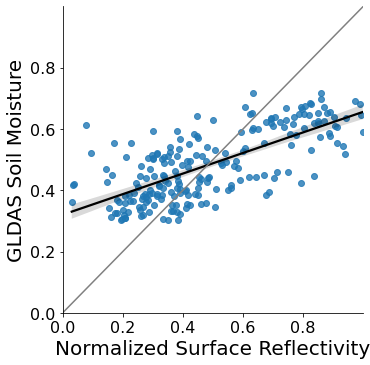

In [53]:
%%time
Lat = [26]#,22,23,24,25,26,27,28,29,30]
Lon = [87]#,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89]
for i in range(len(Lat)):
    lat = str(Lat[i])
    for j in range(len(Lon)):
        lon = str(Lon[j])
        path = 'D:\EG\Project Data\GLDAS_SM\CYGNSS_SR_GLDAS_SM\\'
        Path1 = path + 'Annual_Variations_' + lat + '_' + lon + '.csv'
        R1.SR_GLDAS_SM_Corr(Path1,lat,lon)

# Temporal correlation of SMAP with ESA 
+ Let's see the variance in two different models of soil moisture
+ We have considered the first reference soil moisture as SMAP by SCA model and 2nd from GLDAS model
+ ESA CCI has 25km x 25 km resolution
+ SMAP has 36 km x 36 km resolution
+ So we need to take the average of all the pixels of ESA CCI corresponding to the 1 pixel of SMAP for entire 2020 year
+ Then make temporal correlation between both soil moisture data

In [54]:
import For_Validating_Model_SMAP_SM
import imp
imp.reload(For_Validating_Model_SMAP_SM)
import For_Validating_Model_SMAP_SM as SC1

### ESA CCI Soil Moisture

In [55]:
## Saving files containing ESA CCI soil moisture of whole year for a single pixel of SMAP

## Latitude and longitude of centroid of a single grid cell of SMAP
# lat = [21.18]
# lon = [73.18]
# for i in range(len(lat)):
#     lat1 = lat[i]
#     for j in range(len(lon)):
#         lon1 = lon[j]
#         SC1.SM_ESA_CCI(1,366,lat1,lon1)

### SMAP Soil Moisture

In [56]:
## Saving files containing SMAP soil moisture of whole year for a single pixel

## Latitude and longitude of centroid of a single grid cell of SMAP
# lat = [22.18]
# lon = [78.22]
# for i in range(len(lat)):
#     lat1 = lat[i]
#     for j in range(len(lon)):
#         lon1 = lon[j]
#         SC1.SMAP_SM_availability(1,366,lat1,lon1)

Wall time: 498 ms


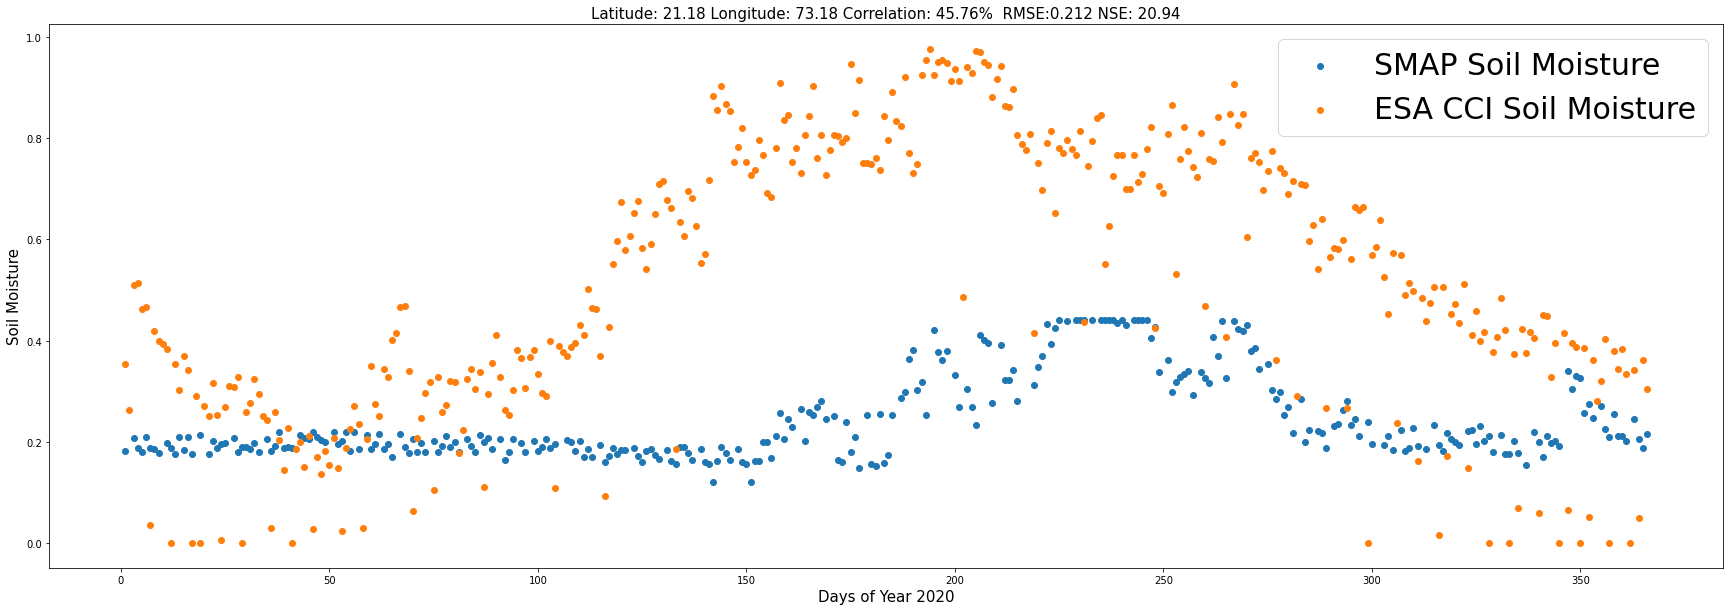

<Figure size 144x144 with 0 Axes>

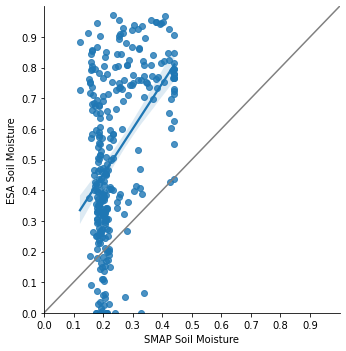

In [57]:
%%time
lat = [21.18]
lon = [73.18]#,73.54,73.9,74.26,74.62,74.98,75.34]
for i in range(len(lat)):
    lat1 = lat[i]
    for j in range(len(lon)):
        lon1 = lon[j]
        SC1.ESA_SMAP_SM_Correlations(lat1,lon1)

+ We can see that both Model is giving different results on a particular pixel
+ There might be some different assumptions during modeling soil moisture by both models